In [76]:
from HeaderP import *


In [77]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection



In [78]:
# from So
from os.path import exists
import io
colnames = ['oid','expid','hjd','mjd','mag','magerr','catflags','filtercode',
                     'ra','dec','chi','sharp','filefracday','field','ccdid','qid','limitmag','magzp',
                     'magzprms','clrcoeff','clrcounc','exptime','airmass','programid']
import requests
def download_ztf_archive_lightcurves(ra, dec, objids=[], sr=0.001, lcout=False):
    ra = str(ra)
    dec = str(dec)
    sr = str(sr)
    
    if exists(f"./lc/ra_{ra}_dec_{dec}_sr_{sr}.pkl"):
        mainlc = pd.read_pickle(f"./lc/ra_{ra}_dec_{dec}_sr_{sr}.pkl")
    else:
        url1 = "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE "
        url2 = f"{ra} {dec} {sr}&BANDNAME=r&NOBS_MIN=30&BAD_CATFLAGS_MASK=32768&FORMAT=ipac_table"
        url = url1 + url2


        r = requests.get(url)

        urlData = r.content

        mainlc = pd.read_table(io.StringIO(urlData.decode('utf-8')),
                              delim_whitespace=True, skiprows=54, names=colnames)
        mainlc.to_pickle(f"./lc/ra_{ra}_dec_{dec}_sr_{sr}.pkl")
    
    return mainlc

    

In [79]:
lc = download_ztf_archive_lightcurves(165.0312,21.247355,objids=[], sr=0.001, lcout=False)


0.0


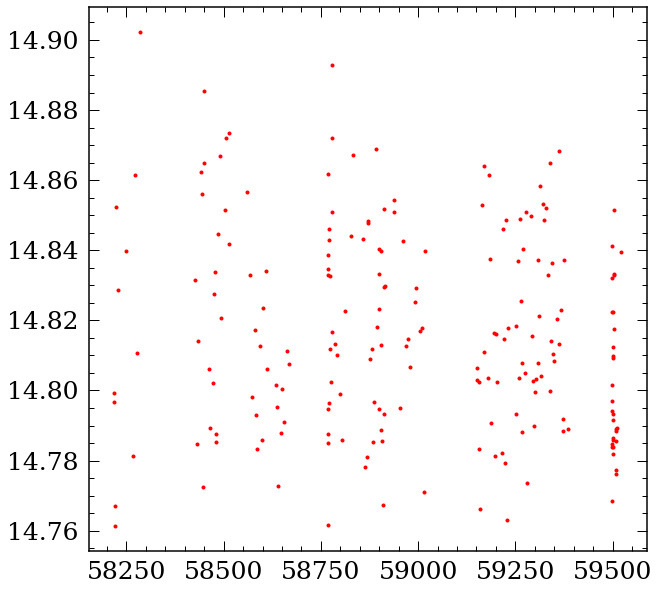

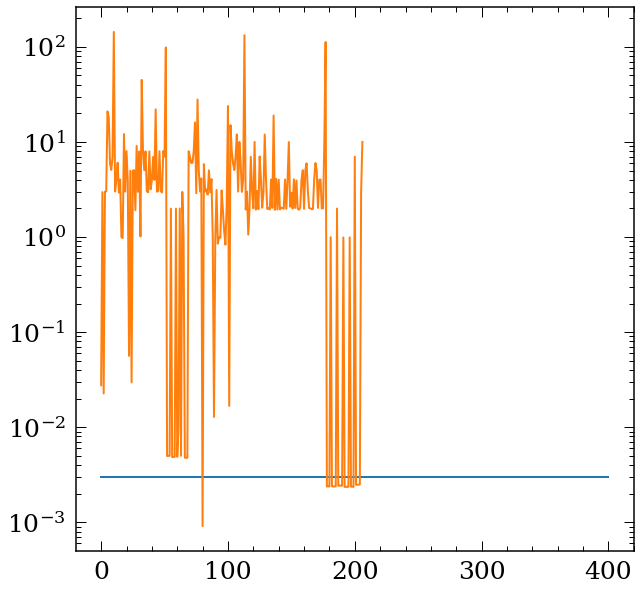

In [80]:
plt.plot(lc['mjd'],lc['mag'],'r.')
print(sum(lc.sort_values(by='mjd')['mjd']-lc['mjd']))
plt.figure()
plt.plot([0,400],[0.003,0.003])
plt.semilogy(np.diff(lc['mjd']))

In [89]:
import io
import os
from astropy.timeseries import LombScargle
import warnings
warnings.filterwarnings('ignore')

def fitpoly(t,mag):
    p = fitpoints(t,mag,2)
    return t, mag-p(t)



def movingMed_time(t, mag, T_window,delta_T_window):
    # add in two columns for the median and put Nan's in them
    t_med=np.empty(len(mag))
    mag_med=np.empty(len(mag))
    t_med[:]=np.nan
    mag_med[:]=np.nan
    
    # define the boundaries of the windows
    window_min=float(min(t))
    window_max=float(window_min+delta_T_window)
    # max time
    maxtime=max(t)
    # break when time window hits the end
    while window_max<=maxtime+T_window:
        seldf=((t>=window_min) & (t<=window_max)) # get points between the window
        
        t_med[seldf]=np.median(t[seldf]) # all values for these indices are subsituded with median time
        mag_med[seldf]=np.median(mag[seldf]) # all values for these indices are subsituded with median flux

        window_min=window_min+delta_T_window
        window_max=window_max+delta_T_window
    return t_med, mag_med

import time
def processlc(maincord, searchradius=5, magrange=1, pltorg=False, splitlc=True, autls=True,
             protmeas=np.linspace(1,200,500),savefigname=[],falarm=False):
    # search radius is arcmin
    colnames = ['oid','expid','hjd','mjd','mag','magerr','catflags','filtercode',
                     'ra','dec','chi','sharp','filefracday','field','ccdid','qid','limitmag','magzp',
                     'magzprms','clrcoeff','clrcounc','exptime','airmass','programid']
    
    t1 = time.perf_counter()
    mainlc = download_ztf_archive_lightcurves(maincord[0], maincord[1], sr=0.001, lcout=True)
    mainlc = mainlc.loc[mainlc['oid']==mainlc['oid'][0]].reset_index(drop=True)
    mainlc = mainlc.dropna(subset=['mjd','mag','magerr']).reset_index(drop=True)
    ######### quality flags below this line #########
    mainlc = mainlc.loc[mainlc['airmass']<1.8].reset_index(drop=True)
    mainlc = mainlc.loc[mainlc['limitmag']>19.5].reset_index(drop=True)
    ######### quality flags above this line #########
    mainlc = mainlc[['oid','mjd','mag','magerr']]
    mainlc = mainlc.sort_values(by='mjd').reset_index(drop=True)
    
    
    lcs = download_ztf_archive_lightcurves(maincord[0], maincord[1], sr=searchradius/60, lcout=True)
    lcs = lcs.dropna(subset=['mjd','mag','magerr']).reset_index(drop=True)
    ######### quality flags below this line #########
    lcs = lcs.loc[lcs['airmass']<1.8].reset_index(drop=True)
    lcs = lcs.loc[lcs['limitmag']>19.5].reset_index(drop=True)
    ######### quality flags above this line #########
    lcs = lcs[['oid','mjd','mag','magerr']]
    t2 = time.perf_counter()
    
    nearlcs = lcs.loc[~lcs['oid'].isin(mainlc['oid'].unique())].reset_index(drop=True)
    m = abs(nearlcs['mag']-np.median(mainlc['mag']))<magrange
    nearlcs = nearlcs[m].reset_index(drop=True)
    nearlc_ids = nearlcs['oid'].unique()
    nearbylcs_no = len(nearlc_ids)
    #print('There are nearby %d lcs...'%(nearbylcs_no))
    
    mags = nearlcs['mag']
    for i in trange(nearbylcs_no):
        m = (nearlcs['oid'] == nearlc_ids[i])
        mags[m] = mags[m]-np.median(mags[m])
        
    nearlcs['mag'] = mags
    
    lctime = mainlc['mjd'].values-min(mainlc['mjd'].values)
    lcmags = mainlc['mag'].values
    lcmags_err = mainlc['magerr'].values
    
    
    if pltorg:
        print('LG orginal lcs...')
        plt.figure(figsize=(30,16))
        plt.subplot(2,3,1)
        plt.plot(lctime, lcmags, 'ro', markersize=10, label='pre process')
        plt.xlabel('Time [days]')
        plt.ylabel('Magnitude')
        plt.ylim([min(lcmags),max(lcmags)])
        plt.gca().invert_yaxis()
        plt.title('Origenal lc',fontsize=25)
        
        
        if autls:
            frequency, power = LombScargle(lctime * u.day, lcmags * u.mag, 
                                       lcmags_err * u.mag).autopower()
            prots = 1/frequency
            
        else:
            prots = protmeas*u.day
            frequency = 1/prots
            power = LombScargle(lctime * u.day, lcmags * u.mag, 
                                       lcmags_err * u.mag).power(frequency)
        best_frequency = frequency[np.argmax(power)]
        medpower_org = np.median(power)
        
        plt.subplot(2,3,2)
        P = 1/best_frequency
        t_fold=(lctime-np.median(lctime))-np.round((lctime-np.median(lctime))/P.value)*P.value
        plt.plot(t_fold,  lcmags, 'ko', markersize=10)   
        t_fold, mag = zip(*sorted(zip(t_fold, lcmags)))
        plt.xlabel('Period [Day]')
        plt.ylabel('Power')
        plt.tight_layout()
        plt.ylim([min(lcmags),max(lcmags)])
        plt.title('Prot = %.2f days'%(P.value), fontsize=25)
        plt.gca().invert_yaxis()
        
        plt.subplot(2,3,3)
        plt.semilogx(1/frequency, power, 'k-')   
        plt.xlim(1,200)
        plt.xlabel('Period [Day]')
        plt.ylabel('Power')
        plt.ylim([0,max(power)])
        plt.title('(ra, dec) = ('+str(maincord[0])+', '+str(maincord[1])+')',fontsize=25)
        plt.tight_layout()       
    else:
        if autls:
            frequency, power = LombScargle(lctime * u.day, lcmags * u.mag, 
                                       lcmags_err * u.mag).autopower()
            prots = 1/frequency
            
        else:
            prots = protmeas*u.day
            frequency = 1/prots
            power = LombScargle(lctime * u.day, lcmags * u.mag, 
                                       lcmags_err * u.mag).power(frequency)
        best_frequency = frequency[np.argmax(power)]
        medpower_org = np.median(power)
        
    """
    timediff = np.append([0], np.diff(lctime))
    m = (timediff>0.003)|(timediff==0)
    lctime, lcmags, lcmags_err = lctime[m], lcmags[m], lcmags_err[m]
    """
    timediff = np.append([0], np.diff(lctime))
    if splitlc:
        splits_m = (timediff>80)
        numb_splits = int(sum(splits_m))
        splittimes = lctime[splits_m]
        #print('splitting into %d lcs...'%(numb_splits+1))
        if (numb_splits)==0:
            #print('no lc to split...')
            splitlc=False
        
    
    lcmags = lcmags-np.median(lcmags)
     
    nearlc_time = nearlcs['mjd'].values-min(mainlc['mjd'].values)
    nearlc_mag = nearlcs['mag'].values
    
    lcmags_new = np.zeros(len(lctime))
    for i in range(len(lctime)):
        m = (nearlc_time == lctime[i])
        if sum(m)==0:
            lcmags_new[i] = lcmags[i]
        else:
            lcmags_new[i] = lcmags[i]-np.median(nearlc_mag[m])
    lcmags_new = lcmags_new-np.median(lcmags_new)
    
    if splitlc:
        lctime_sing, lcmags_sing, lcmags_err_sing = [], [], []
        for i in range(-1, numb_splits+1):
            if i==0:
                msplit = (lctime<splittimes[0])
            elif i==(numb_splits):
                msplit = (lctime>=splittimes[i-1])
            elif i==-1:
                msplit = (lctime>0)
            else:
                msplit = (lctime>=splittimes[i-1])&(lctime<splittimes[i])

            
            if sum(msplit)<30:
                continue
            # split into single season + overall ones
            lctime_sing1, lcmags_new_sing1, lcmags_err_sing1 = lctime[msplit], lcmags_new[msplit], lcmags_err[msplit]
            
            # get rid of outliers
            good_ind = abs(lcmags_new_sing1-np.median(lcmags_new_sing1))<3*np.std(lcmags_new_sing1)
            lctime_sing1, lcmags_new_sing1, lcmags_err_sing1 = lctime_sing1[good_ind], lcmags_new_sing1[good_ind], lcmags_err_sing1[good_ind]
            
            # 
            lctime_sing.append(lctime_sing1)
            lcmags_sing.append(lcmags_new_sing1-np.median(lcmags_new_sing1)) 
            lcmags_err_sing.append(lcmags_err_sing1)
        #print('splitting into %d lcs...'%(len(lctime_sing)))
            
    else:
        lctime_sing, lcmags_sing, lcmags_err_sing = [], [], []
        good_ind = abs(lcmags_new-np.median(lcmags_new))<3*np.std(lcmags_new)
        lctime_sing.append(lctime[good_ind])
        lcmags_sing.append(lcmags_new[good_ind]-np.median(lcmags_new[good_ind])) 
        lcmags_err_sing.append(lcmags_err[good_ind])
        
        
    if pltorg:
        #print('LG post processed lcs...')
        plt.subplot(2,3,4)
        minyylim = 100
        maxylim = -100
        for i in range(len(lctime_sing)):
            plt.plot(lctime_sing[i], lcmags_sing[i], 'o', markersize=10)
            plt.xlabel('Time [days]')
            plt.ylabel('normaized magnitude (post)')
            minyylim = min([minyylim, min(lcmags_sing[i])])
            maxylim = max([maxylim, max(lcmags_sing[i])])
        plt.ylim([minyylim, maxylim])
        plt.gca().invert_yaxis()
        plt.title('Processed lc',fontsize=25)
        
        plt.subplot(2,3,5)
        frequency, power, bestfreq, bestpower, Ps, medpower,fa = [], [], [], [], [], [],[]
        minyylim = 100
        maxylim = -100
        for i in range(len(lctime_sing)):
            ls = LombScargle(lctime_sing[i] * u.day, lcmags_sing[i] * u.mag, 
                                           lcmags_err_sing[i] * u.mag)
            if autls:
                timerange = 1/((max(lctime_sing[i])-min(lctime_sing[i]))/2)
                frequency_1, power_1 = ls.autopower(minimum_frequency=timerange*1/u.day)
                prots = 1/frequency_1

            else:
                prots = protmeas*u.day
                frequency_1 = 1/prots
                power_1 = ls.power(frequency_1)
            best_frequency_1 = frequency_1[np.argmax(power_1)]
            
            P = 1/best_frequency_1
            
            Ps.append(P)
            bestfreq.append(best_frequency_1)
            frequency.append(frequency_1)
            power.append(power_1)
            bestpower.append(max(power_1))
            medpower.append(np.median(power_1))
            fa.append(ls.false_alarm_probability(max(power_1)))
            
            t_fold=(lctime_sing[i]-np.median(lctime_sing[i]))-np.round((lctime_sing[i]-np.median(lctime_sing[i]))/P.value)*P.value
            plt.plot(t_fold/(max(t_fold)-min(t_fold)),  lcmags_sing[i]+0.1*i, 'o', label='Prot=%.2f'%P.value, markersize=10)   
            minyylim = min([minyylim, min(lcmags_sing[i]+0.1*i)])
            maxylim = max([maxylim, max(lcmags_sing[i]+0.1*i)])
            plt.xlabel('Normalized Time [Day]')
            plt.ylabel('Power')
            plt.tight_layout()
            
        
        plt.legend()
        plt.ylim([minyylim-0.05,maxylim+0.05])
        plt.gca().invert_yaxis()
        
        
        plt.subplot(2,3,6)
        maxpower = 0
        for i in range(len(lctime_sing)):
            plt.semilogx(1/frequency[i], power[i], '-')   
            plt.xlim(0,200)
            plt.xlabel('Period [Day]')
            plt.ylabel('Power')
            maxpower = max([maxpower, max(power[i])])
        plt.ylim([0,maxpower])
        plt.title('(ra, dec) = ('+str(maincord[0])+', '+str(maincord[1])+')',fontsize=25)
        plt.tight_layout()
        if len(savefigname)!=0:
            plt.savefig(savefigname)
            plt.close()
        
        
    else:
        frequency, power, bestfreq, bestpower, Ps, medpower, fa = [], [], [], [], [], [], []
        for i in range(len(lctime_sing)):
            ls = LombScargle(lctime_sing[i] * u.day, lcmags_sing[i] * u.mag, 
                                           lcmags_err_sing[i] * u.mag)
            
            if autls:
                frequency_1, power_1 = ls.autopower(minimum_frequency=0.005*1/u.day)
                prots = 1/frequency_1
                

            else:
                prots = protmeas*u.day
                frequency_1 = 1/prots
                power_1 = ls.power(frequency_1)
                
            best_frequency_1 = frequency_1[np.argmax(power_1)]
            
            P = 1/best_frequency_1
            
            Ps.append(P)
            bestfreq.append(best_frequency_1)
            frequency.append(frequency_1)
            power.append(power_1)
            bestpower.append(max(power_1))
            medpower.append(np.median(power_1))
            fa.append(ls.false_alarm_probability(power_1))
            
            t_fold=(lctime_sing[i]-np.median(lctime_sing[i]))-np.round((lctime_sing[i]-np.median(lctime_sing[i]))/P.value)*P.value
            t_fold, mag = zip(*sorted(zip(t_fold, lcmags_sing[i])))
            
        
    t3 = time.perf_counter()
    
    if falarm:
        return lctime, lcmags, [i.value for i in Ps], [i.value for i in bestpower], medpower_org, [i.value for i in medpower], [i.value for i in fa], t2-t1, t3-t2, nearbylcs_no

    else:
        return lctime, lcmags, [i.value for i in Ps], [i.value for i in bestpower], medpower_org, [i.value for i in medpower], t2-t1, t3-t2, nearbylcs_no

 
        
    



100%|██████████| 16/16 [00:00<00:00, 641.53it/s]


LG orginal lcs...


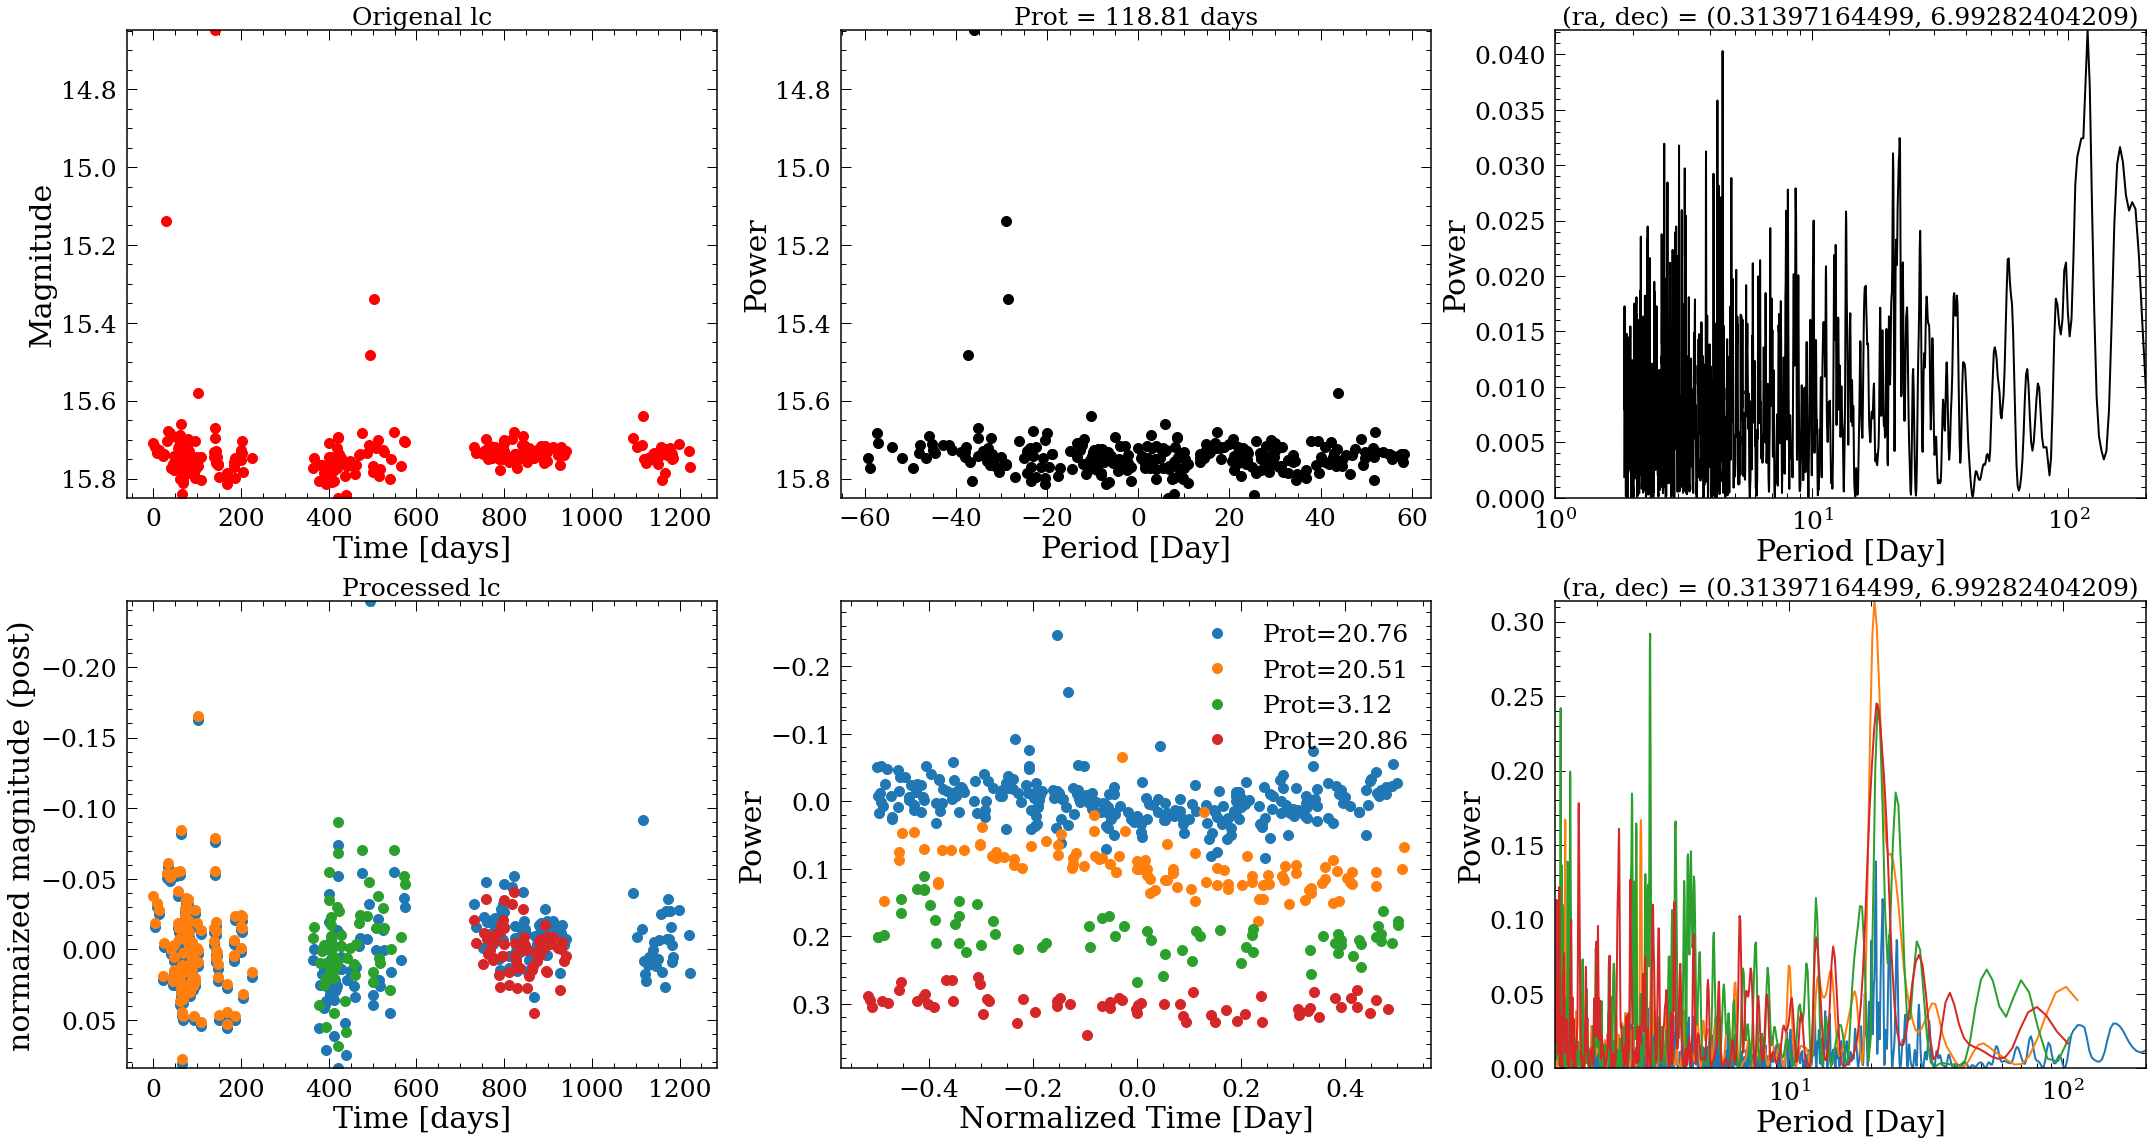

In [60]:
t, mag, p, bp, medporg, medpowers, t1, t2, nl = processlc([0.31397164499,6.99282404209], searchradius=4, magrange=2, pltorg=True, splitlc=True, autls=True)
    

100%|██████████| 2/2 [00:00<00:00, 279.37it/s]


LG orginal lcs...


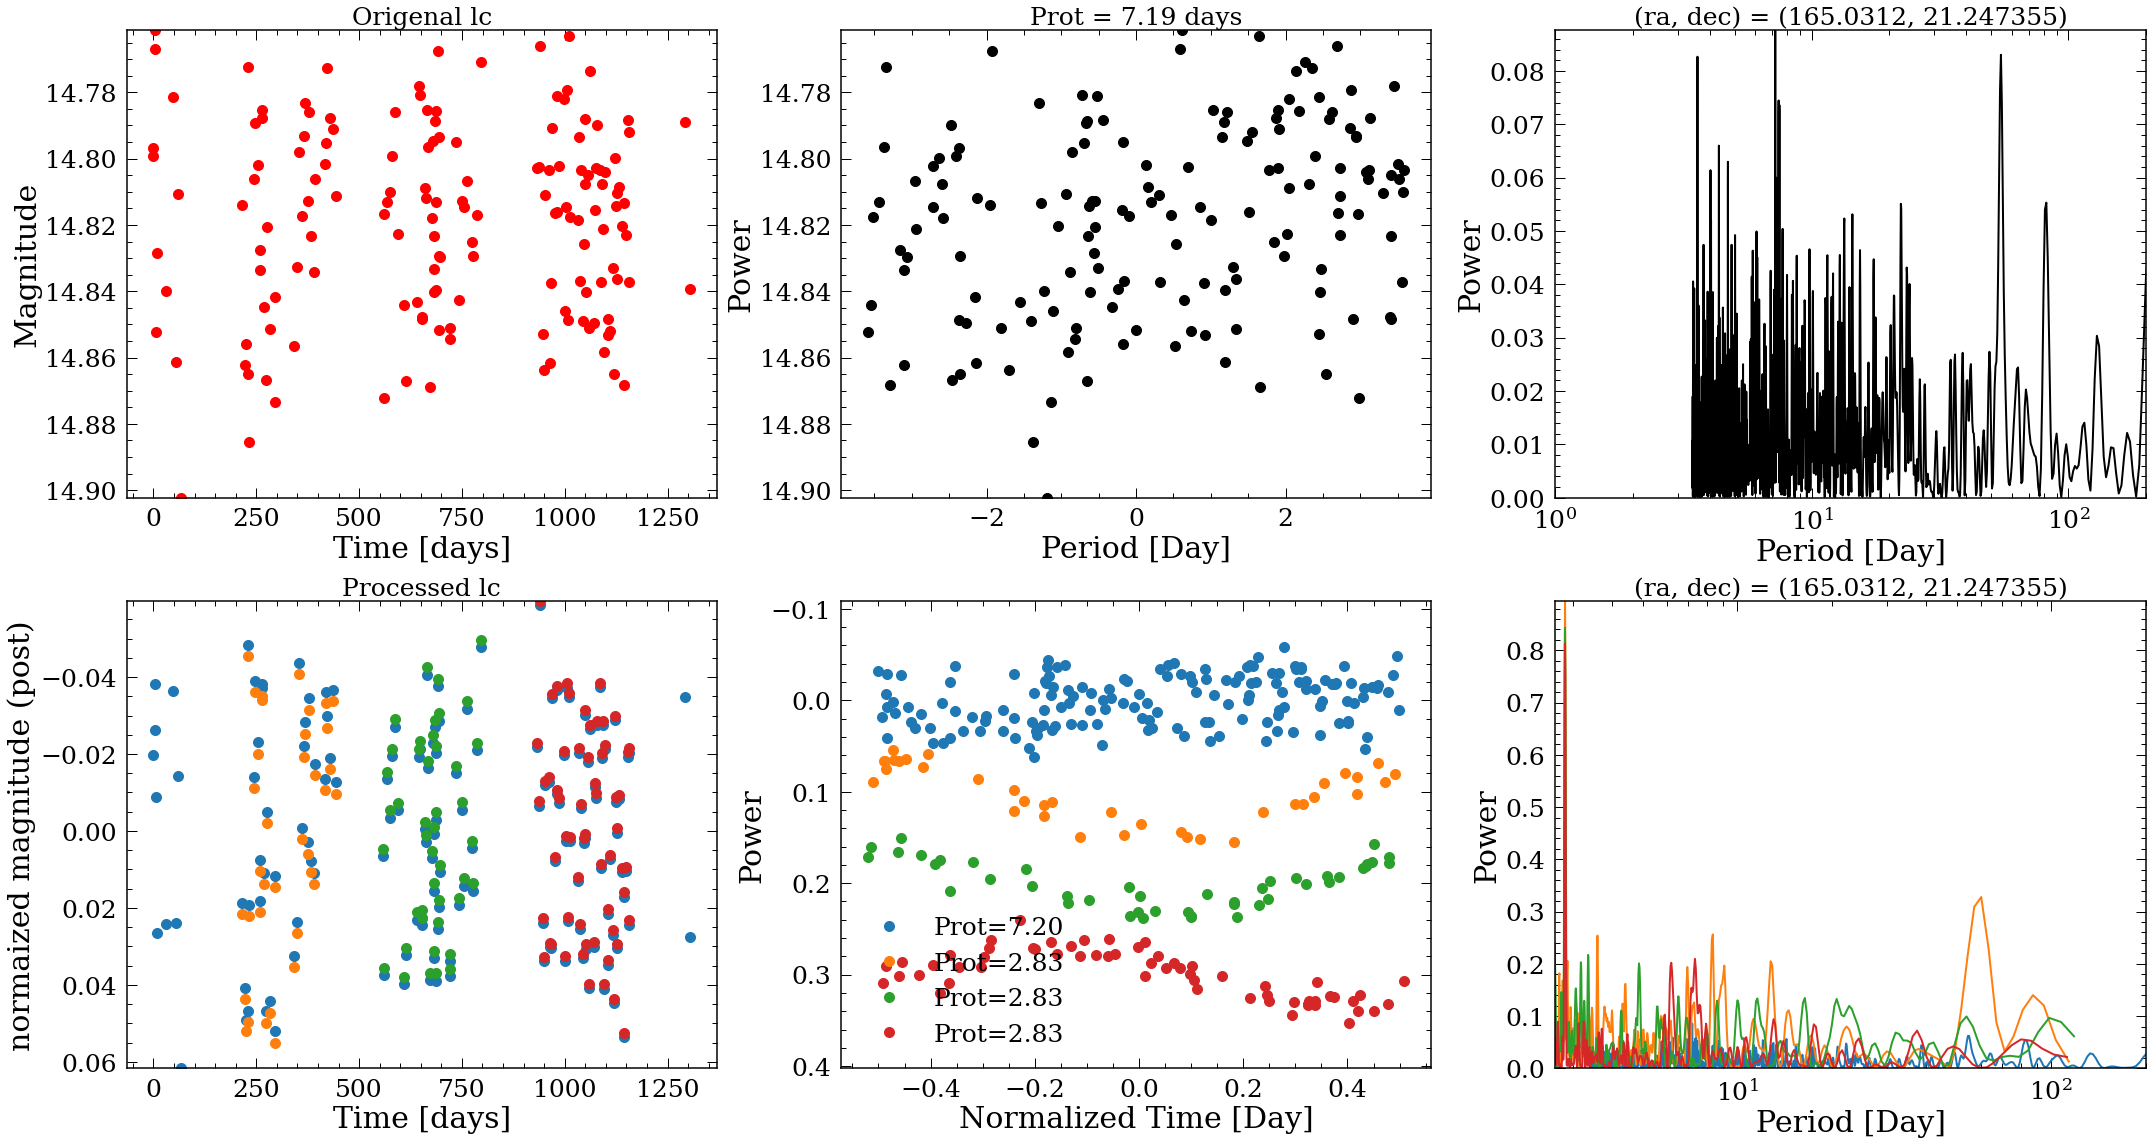

In [90]:
t, mag, p, bp, medporg, medpowers, fa, t1, t2, nl = processlc([165.0312,21.247355], searchradius=4, magrange=2, pltorg=True, splitlc=True, autls=True,falarm=True)
    

In [62]:
radec = pd.read_csv('MEarth_Rotator_List_v2.csv')
len(radec)

387

# get gaia mag

In [63]:
from astroquery.gaia import Gaia
radius = u.Quantity(0.003, u.deg)
ids = radec['2MASS'].values
Gaia.ROW_LIMIT = 1
mags = np.zeros(len(radec))*np.nan
for i in trange(len(radec)):
    star_name = "2MASS "+ids[i]
    c = SkyCoord.from_name(star_name, frame='icrs')
    j = Gaia.cone_search_async(c, radius)
    r = j.get_results()
    try:
        mags[i] = r['phot_g_mean_mag'].value.data[0]
    except:
        continue

  0%|          | 1/387 [00:04<27:38,  4.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|          | 2/387 [00:07<23:01,  3.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|          | 3/387 [00:11<23:15,  3.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|          | 4/387 [00:14<21:50,  3.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▏         | 5/387 [00:15<16:58,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|▏         | 6/387 [00:18<16:54,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|▏         | 7/387 [00:20<17:07,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|▏         | 8/387 [00:22<14:18,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|▏         | 9/387 [00:24<15:09,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|▎         | 10/387 [00:26<13:01,  2.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|▎         | 11/387 [00:28<14:03,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|▎         | 12/387 [00:31<15:05,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|▎         | 13/387 [00:34<15:35,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|▎         | 14/387 [00:37<15:55,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|▍         | 15/387 [00:39<16:07,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|▍         | 16/387 [00:43<18:20,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|▍         | 17/387 [00:44<15:15,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|▍         | 18/387 [00:47<15:46,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|▍         | 19/387 [00:51<17:50,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|▌         | 20/387 [00:55<19:03,  3.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|▌         | 21/387 [00:57<18:10,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|▌         | 22/387 [01:01<19:18,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|▌         | 23/387 [01:04<18:20,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|▌         | 24/387 [01:06<17:43,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|▋         | 25/387 [01:11<20:17,  3.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|▋         | 26/387 [01:13<19:08,  3.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|▋         | 27/387 [01:16<18:37,  3.10s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|▋         | 28/387 [01:18<15:23,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|▋         | 29/387 [01:23<19:38,  3.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|▊         | 30/387 [01:25<18:52,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|▊         | 31/387 [01:27<15:32,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|▊         | 32/387 [01:28<13:12,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|▊         | 33/387 [01:32<15:38,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|▉         | 34/387 [01:34<15:36,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|▉         | 35/387 [01:38<17:36,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|▉         | 36/387 [01:41<17:53,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|▉         | 37/387 [01:43<14:48,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|▉         | 38/387 [01:47<16:56,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█         | 39/387 [01:49<16:29,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█         | 40/387 [01:51<13:49,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|█         | 41/387 [01:52<11:57,  2.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|█         | 42/387 [01:53<10:39,  1.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|█         | 43/387 [01:56<11:54,  2.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|█▏        | 44/387 [01:57<10:35,  1.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|█▏        | 45/387 [01:59<09:42,  1.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|█▏        | 46/387 [02:01<11:33,  2.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|█▏        | 47/387 [02:03<10:19,  1.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|█▏        | 48/387 [02:05<11:44,  2.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█▎        | 49/387 [02:08<12:48,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█▎        | 50/387 [02:11<14:18,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█▎        | 51/387 [02:14<15:19,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█▎        | 52/387 [02:18<16:13,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█▎        | 53/387 [02:19<13:32,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█▍        | 54/387 [02:22<14:04,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█▍        | 55/387 [02:25<14:19,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█▍        | 56/387 [02:26<12:14,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|█▍        | 57/387 [02:29<13:14,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|█▍        | 58/387 [02:32<14:19,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|█▌        | 59/387 [02:33<12:10,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|█▌        | 60/387 [02:36<12:50,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|█▌        | 61/387 [02:39<13:51,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|█▌        | 62/387 [02:40<12:03,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|█▋        | 63/387 [02:43<12:51,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█▋        | 64/387 [02:46<13:18,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█▋        | 65/387 [02:48<13:38,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█▋        | 66/387 [02:50<11:39,  2.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█▋        | 67/387 [02:53<12:43,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|█▊        | 68/387 [02:56<14:02,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|█▊        | 69/387 [02:59<15:29,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|█▊        | 70/387 [03:02<15:04,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|█▊        | 71/387 [03:05<14:54,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|█▊        | 72/387 [03:06<12:30,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|█▉        | 73/387 [03:09<12:57,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|█▉        | 74/387 [03:12<13:32,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|█▉        | 75/387 [03:13<11:31,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█▉        | 76/387 [03:16<12:12,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█▉        | 77/387 [03:19<13:09,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|██        | 78/387 [03:20<11:14,  2.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|██        | 79/387 [03:22<09:53,  1.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|██        | 80/387 [03:23<08:57,  1.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|██        | 81/387 [03:27<11:55,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|██        | 82/387 [03:28<10:21,  2.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|██▏       | 83/387 [03:29<09:18,  1.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██▏       | 84/387 [03:31<08:32,  1.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██▏       | 85/387 [03:32<08:17,  1.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██▏       | 86/387 [03:35<10:00,  2.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██▏       | 87/387 [03:38<11:28,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|██▎       | 88/387 [03:39<10:03,  2.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|██▎       | 89/387 [03:43<12:28,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|██▎       | 90/387 [03:47<14:10,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██▎       | 91/387 [03:49<14:03,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██▍       | 92/387 [03:52<13:41,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██▍       | 93/387 [03:54<12:52,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██▍       | 94/387 [03:58<14:13,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|██▍       | 95/387 [03:59<11:53,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|██▍       | 96/387 [04:03<13:39,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|██▌       | 97/387 [04:06<13:21,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|██▌       | 98/387 [04:10<15:15,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██▌       | 99/387 [04:13<15:00,  3.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██▌       | 100/387 [04:16<15:40,  3.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██▌       | 101/387 [04:20<16:02,  3.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██▋       | 102/387 [04:23<15:04,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██▋       | 103/387 [04:26<15:45,  3.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██▋       | 104/387 [04:32<19:20,  4.10s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██▋       | 105/387 [04:34<15:21,  3.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██▋       | 106/387 [04:37<15:56,  3.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|██▊       | 107/387 [04:40<14:55,  3.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|██▊       | 108/387 [04:43<14:09,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|██▊       | 109/387 [04:47<15:54,  3.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|██▊       | 110/387 [04:50<14:53,  3.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|██▊       | 111/387 [04:53<15:24,  3.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|██▉       | 112/387 [04:56<14:49,  3.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|██▉       | 113/387 [04:58<12:09,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|██▉       | 114/387 [05:01<12:18,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██▉       | 115/387 [05:03<12:13,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██▉       | 116/387 [05:07<14:15,  3.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|███       | 117/387 [05:10<13:32,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|███       | 118/387 [05:11<11:13,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███       | 119/387 [05:14<11:24,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███       | 120/387 [05:15<09:44,  2.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███▏      | 121/387 [05:18<10:19,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|███▏      | 122/387 [05:22<11:54,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|███▏      | 123/387 [05:25<13:16,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|███▏      | 124/387 [05:29<13:59,  3.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|███▏      | 125/387 [05:30<11:30,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|███▎      | 126/387 [05:33<11:29,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|███▎      | 127/387 [05:36<11:32,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|███▎      | 128/387 [05:38<10:58,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|███▎      | 129/387 [05:41<11:12,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███▎      | 130/387 [05:44<12:33,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███▍      | 131/387 [05:49<14:09,  3.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███▍      | 132/387 [05:53<15:03,  3.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███▍      | 133/387 [05:55<13:54,  3.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|███▍      | 134/387 [05:59<14:23,  3.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|███▍      | 135/387 [06:02<13:25,  3.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|███▌      | 136/387 [06:05<12:45,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|███▌      | 137/387 [06:07<12:15,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|███▌      | 138/387 [06:10<11:54,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|███▌      | 139/387 [06:13<12:16,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|███▌      | 140/387 [06:16<11:54,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|███▋      | 141/387 [06:20<12:58,  3.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███▋      | 142/387 [06:22<12:20,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███▋      | 143/387 [06:24<10:13,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███▋      | 144/387 [06:26<10:22,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███▋      | 145/387 [06:29<10:29,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███▊      | 146/387 [06:30<08:55,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███▊      | 147/387 [06:32<07:49,  1.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███▊      | 148/387 [06:35<09:33,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|███▊      | 149/387 [06:38<09:59,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|███▉      | 150/387 [06:39<08:32,  2.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|███▉      | 151/387 [06:42<09:08,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|███▉      | 152/387 [06:45<09:31,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███▉      | 153/387 [06:46<08:13,  2.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███▉      | 154/387 [06:47<07:17,  1.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|████      | 155/387 [06:50<08:12,  2.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|████      | 156/387 [06:53<08:50,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████      | 157/387 [06:55<09:15,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████      | 158/387 [06:58<09:31,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████      | 159/387 [06:59<08:10,  2.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████▏     | 160/387 [07:02<08:43,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|████▏     | 161/387 [07:05<09:07,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|████▏     | 162/387 [07:08<09:25,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|████▏     | 163/387 [07:10<09:33,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|████▏     | 164/387 [07:15<11:44,  3.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████▎     | 165/387 [07:18<12:10,  3.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████▎     | 166/387 [07:21<11:33,  3.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████▎     | 167/387 [07:25<12:18,  3.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████▎     | 168/387 [07:28<11:34,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████▎     | 169/387 [07:30<11:00,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████▍     | 170/387 [07:33<10:42,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████▍     | 171/387 [07:36<10:21,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████▍     | 172/387 [07:39<10:06,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|████▍     | 173/387 [07:42<10:20,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|████▍     | 174/387 [07:44<09:59,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|████▌     | 175/387 [07:47<09:49,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|████▌     | 176/387 [07:48<08:15,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|████▌     | 177/387 [07:51<08:32,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|████▌     | 178/387 [07:56<11:12,  3.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|████▋     | 179/387 [08:01<12:30,  3.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████▋     | 180/387 [08:03<11:36,  3.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████▋     | 181/387 [08:06<11:01,  3.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████▋     | 182/387 [08:09<10:38,  3.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████▋     | 183/387 [08:12<10:11,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|████▊     | 184/387 [08:13<08:27,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|████▊     | 185/387 [08:16<08:40,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|████▊     | 186/387 [08:19<08:45,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|████▊     | 187/387 [08:22<09:53,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|████▊     | 188/387 [08:25<09:35,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|████▉     | 189/387 [08:28<09:49,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|████▉     | 190/387 [08:30<08:09,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|████▉     | 191/387 [08:32<08:24,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|████▉     | 192/387 [08:35<08:28,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|████▉     | 193/387 [08:38<08:37,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|█████     | 194/387 [08:41<08:37,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|█████     | 195/387 [08:43<08:35,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|█████     | 196/387 [08:46<08:41,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|█████     | 197/387 [08:49<08:40,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|█████     | 198/387 [08:52<08:51,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|█████▏    | 199/387 [08:55<08:43,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|█████▏    | 200/387 [08:56<07:19,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|█████▏    | 201/387 [08:57<06:20,  2.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|█████▏    | 202/387 [08:59<05:38,  1.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|█████▏    | 203/387 [09:01<06:25,  2.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████▎    | 204/387 [09:04<07:00,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████▎    | 205/387 [09:05<06:05,  2.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████▎    | 206/387 [09:08<06:39,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████▎    | 207/387 [09:11<07:04,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████▎    | 208/387 [09:14<07:21,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████▍    | 209/387 [09:16<07:24,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████▍    | 210/387 [09:17<06:20,  2.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|█████▍    | 211/387 [09:19<05:35,  1.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|█████▍    | 212/387 [09:22<07:04,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|█████▌    | 213/387 [09:25<07:16,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|█████▌    | 214/387 [09:28<07:24,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████▌    | 215/387 [09:31<07:54,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████▌    | 216/387 [09:34<08:13,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████▌    | 217/387 [09:37<08:26,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████▋    | 218/387 [09:44<11:33,  4.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████▋    | 219/387 [09:46<09:09,  3.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████▋    | 220/387 [09:51<11:01,  3.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████▋    | 221/387 [09:53<09:33,  3.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████▋    | 222/387 [09:56<08:57,  3.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|█████▊    | 223/387 [10:00<09:06,  3.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|█████▊    | 224/387 [10:03<09:17,  3.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|█████▊    | 225/387 [10:05<07:32,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|█████▊    | 226/387 [10:07<07:04,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|█████▊    | 227/387 [10:08<05:58,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|█████▉    | 228/387 [10:11<06:15,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|█████▉    | 229/387 [10:13<06:25,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|█████▉    | 230/387 [10:15<05:30,  2.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████▉    | 231/387 [10:16<04:52,  1.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████▉    | 232/387 [10:17<04:25,  1.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|██████    | 233/387 [10:21<05:40,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|██████    | 234/387 [10:24<06:01,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████    | 235/387 [10:26<06:15,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████    | 236/387 [10:28<05:21,  2.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████    | 237/387 [10:30<05:52,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████▏   | 238/387 [10:33<06:15,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|██████▏   | 239/387 [10:37<07:10,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|██████▏   | 240/387 [10:40<07:00,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|██████▏   | 241/387 [10:43<06:55,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|██████▎   | 242/387 [10:46<07:05,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|██████▎   | 243/387 [10:47<05:53,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|██████▎   | 244/387 [10:49<05:02,  2.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|██████▎   | 245/387 [10:52<05:58,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|██████▎   | 246/387 [10:53<05:05,  2.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|██████▍   | 247/387 [10:55<04:28,  1.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|██████▍   | 248/387 [10:57<04:57,  2.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|██████▍   | 249/387 [11:00<05:17,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████▍   | 250/387 [11:03<05:31,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████▍   | 251/387 [11:06<06:18,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████▌   | 252/387 [11:10<06:31,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████▌   | 253/387 [11:12<06:20,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|██████▌   | 254/387 [11:16<07:05,  3.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|██████▌   | 255/387 [11:19<06:24,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|██████▌   | 256/387 [11:22<06:54,  3.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|██████▋   | 257/387 [11:25<06:32,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|██████▋   | 258/387 [11:29<06:56,  3.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|██████▋   | 259/387 [11:31<06:32,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|██████▋   | 260/387 [11:34<06:14,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|██████▋   | 261/387 [11:37<06:02,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|██████▊   | 262/387 [11:38<05:02,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|██████▊   | 263/387 [11:43<06:31,  3.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|██████▊   | 264/387 [11:44<05:21,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|██████▊   | 265/387 [11:46<04:31,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|██████▊   | 266/387 [11:48<04:51,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|██████▉   | 267/387 [11:52<05:16,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|██████▉   | 268/387 [11:55<05:33,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|██████▉   | 269/387 [11:59<06:33,  3.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|██████▉   | 270/387 [12:03<06:27,  3.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|███████   | 271/387 [12:06<06:19,  3.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|███████   | 272/387 [12:09<06:03,  3.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████   | 273/387 [12:11<05:44,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████   | 274/387 [12:16<06:25,  3.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████   | 275/387 [12:18<05:57,  3.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████▏  | 276/387 [12:21<05:37,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████▏  | 277/387 [12:26<06:24,  3.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████▏  | 278/387 [12:28<05:56,  3.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████▏  | 279/387 [12:31<05:32,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████▏  | 280/387 [12:36<06:37,  3.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|███████▎  | 281/387 [12:41<06:52,  3.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|███████▎  | 282/387 [12:44<06:39,  3.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|███████▎  | 283/387 [12:49<06:58,  4.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|███████▎  | 284/387 [12:51<06:11,  3.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|███████▎  | 285/387 [12:54<05:40,  3.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|███████▍  | 286/387 [12:58<05:45,  3.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|███████▍  | 287/387 [13:00<05:19,  3.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|███████▍  | 288/387 [13:03<05:02,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████▍  | 289/387 [13:04<04:09,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████▍  | 290/387 [13:09<04:54,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████▌  | 291/387 [13:13<05:36,  3.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████▌  | 292/387 [13:16<05:25,  3.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|███████▌  | 293/387 [13:22<06:17,  4.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|███████▌  | 294/387 [13:25<05:45,  3.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|███████▌  | 295/387 [13:28<05:13,  3.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|███████▋  | 296/387 [13:29<04:13,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|███████▋  | 297/387 [13:32<04:32,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|███████▋  | 298/387 [13:36<04:48,  3.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|███████▋  | 299/387 [13:38<03:54,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████▊  | 300/387 [13:40<03:47,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████▊  | 301/387 [13:42<03:38,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████▊  | 302/387 [13:44<03:05,  2.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████▊  | 303/387 [13:45<02:41,  1.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|███████▊  | 304/387 [13:46<02:24,  1.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|███████▉  | 305/387 [13:49<02:45,  2.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|███████▉  | 306/387 [13:52<02:57,  2.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|███████▉  | 307/387 [13:54<03:05,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|███████▉  | 308/387 [13:57<03:21,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|███████▉  | 309/387 [14:00<03:20,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|████████  | 310/387 [14:01<02:49,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|████████  | 311/387 [14:03<02:27,  1.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████  | 312/387 [14:05<02:40,  2.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████  | 313/387 [14:08<03:00,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████  | 314/387 [14:10<02:33,  2.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████▏ | 315/387 [14:11<02:14,  1.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████▏ | 316/387 [14:14<02:31,  2.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████▏ | 317/387 [14:16<02:41,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████▏ | 318/387 [14:19<02:47,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████▏ | 319/387 [14:22<02:51,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|████████▎ | 320/387 [14:25<02:52,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|████████▎ | 321/387 [14:27<02:53,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|████████▎ | 322/387 [14:30<02:57,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|████████▎ | 323/387 [14:32<02:28,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████▎ | 324/387 [14:33<02:07,  2.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████▍ | 325/387 [14:34<01:52,  1.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████▍ | 326/387 [14:36<01:41,  1.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████▍ | 327/387 [14:38<01:58,  1.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████▍ | 328/387 [14:42<02:26,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████▌ | 329/387 [14:46<02:48,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████▌ | 330/387 [14:49<02:41,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|████████▌ | 331/387 [14:54<03:26,  3.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|████████▌ | 332/387 [14:57<03:07,  3.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|████████▌ | 333/387 [15:00<02:52,  3.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|████████▋ | 334/387 [15:03<02:43,  3.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|████████▋ | 335/387 [15:06<02:46,  3.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|████████▋ | 336/387 [15:09<02:36,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|████████▋ | 337/387 [15:12<02:27,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|████████▋ | 338/387 [15:15<02:35,  3.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████▊ | 339/387 [15:18<02:24,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████▊ | 340/387 [15:19<01:57,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████▊ | 341/387 [15:21<01:39,  2.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████▊ | 342/387 [15:22<01:25,  1.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|████████▊ | 343/387 [15:24<01:33,  2.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|████████▉ | 344/387 [15:27<01:38,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|████████▉ | 345/387 [15:30<01:41,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|████████▉ | 346/387 [15:31<01:26,  2.10s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|████████▉ | 347/387 [15:33<01:14,  1.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|████████▉ | 348/387 [15:35<01:22,  2.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|█████████ | 349/387 [15:38<01:27,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|█████████ | 350/387 [15:41<01:34,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|█████████ | 351/387 [15:44<01:32,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|█████████ | 352/387 [15:48<01:50,  3.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|█████████ | 353/387 [15:52<01:50,  3.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|█████████▏| 354/387 [15:55<01:51,  3.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████▏| 355/387 [15:57<01:28,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████▏| 356/387 [16:00<01:28,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████▏| 357/387 [16:02<01:24,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|█████████▎| 358/387 [16:06<01:28,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|█████████▎| 359/387 [16:09<01:22,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|█████████▎| 360/387 [16:14<01:39,  3.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|█████████▎| 361/387 [16:17<01:31,  3.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|█████████▎| 362/387 [16:19<01:11,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|█████████▍| 363/387 [16:21<01:04,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|█████████▍| 364/387 [16:25<01:09,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|█████████▍| 365/387 [16:27<01:03,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████▍| 366/387 [16:30<00:59,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████▍| 367/387 [16:46<02:13,  6.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████▌| 368/387 [16:47<01:36,  5.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████▌| 369/387 [16:50<01:18,  4.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|█████████▌| 370/387 [16:53<01:10,  4.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|█████████▌| 371/387 [16:57<01:03,  3.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|█████████▌| 372/387 [16:58<00:47,  3.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|█████████▋| 373/387 [17:02<00:46,  3.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|█████████▋| 374/387 [17:06<00:44,  3.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|█████████▋| 375/387 [17:07<00:33,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|█████████▋| 376/387 [17:10<00:30,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|█████████▋| 377/387 [17:12<00:27,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████▊| 378/387 [17:16<00:26,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████▊| 379/387 [17:19<00:23,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████▊| 380/387 [17:21<00:19,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████▊| 381/387 [17:25<00:18,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|█████████▊| 382/387 [17:26<00:12,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|█████████▉| 383/387 [17:30<00:11,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|█████████▉| 384/387 [17:32<00:08,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|█████████▉| 385/387 [17:36<00:05,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|█████████▉| 386/387 [17:39<00:03,  3.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|██████████| 387/387 [17:43<00:00,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


In [64]:
radec['gmag'] = mags

In [65]:
gaia = pd.read_csv('MEarth_Rotator_List.csv')

# Calculate rotation periods

In [ ]:
from IPython.display import clear_output
from astropy.coordinates import SkyCoord
import sys
ras = radec['RA'].values
decs = radec['Dec'].values
ids = radec['2MASS'].values
allids = []
allps = []

filename = 'ztfProts_split_newrun_fa'
f = open(filename, 'w+')
f.write('id,prot1,prot2,prot3,prot4,prot5,prot6,prot7,maxpower1,maxpower2,maxpower3,maxpower4,maxpower5,maxpower6,maxpower7,medpower_org,medpower1,medpower2,medpower3,medpower4,medpower5,medpower6,medpower7,fa1,fa2,fa3,fa4,fa5,fa6,fa7,nl\n')
f.flush()
for i in trange(len(radec)):
    clear_output(wait=True)
    print(ras[i], decs[i]) 
    try:
        mainlc = download_ztf_archive_lightcurves(ras[i], decs[i], sr=0.001, 
                                              lcout=True)
    except:
        continue
    figname = 'ztf/'+str(ids[i])+'_split.png'
    if len(mainlc)<100:
        try:
            lctime, lcmags, p, maxpower, medpower_org, medpower, fa, dt, tt, nl = processlc([ras[i], decs[i]], 
                  searchradius=4, magrange=2, pltorg=True, splitlc=False, savefigname=figname, falarm = True)
            plt.close()
        except:
            continue
    else:
        try:
            lctime, lcmags, p, maxpower, medpower_org, medpower, fa, dt, tt, nl = processlc([ras[i], decs[i]], 
              searchradius=4, magrange=2, pltorg=True,savefigname=figname, falarm = True)
            plt.close()
        except:
            continue

    fline = str(ids[i])
    for j in range(7):
        try:
            fline = fline+','+str(p[j])
        except:
            fline = fline+','+'nan'
    for j in range(7):
        try:
            fline = fline+','+str(maxpower[j])
        except:
            fline = fline+','+'nan'
    fline = fline+','+str(medpower_org)
    for j in range(7):
        try:
            fline = fline+','+str(medpower[j])
        except:
            fline = fline+','+'nan'
    for j in range(7):
        try:
            fline = fline+','+str(fa[j])
        except:
            fline = fline+','+'nan'
        
    f.write(fline+','+str(nl)+'\n')
    f.flush()
                




15.49558570667 54.18217771927



0it [00:00, ?it/s]


LG orginal lcs...


# optimized $\Delta$M and search radius

In [ ]:
import random
magsearch = np.linspace(1,4,int((4-1)/0.5))
radsearch = np.linspace(1,6,5)
teststars = 5

allids = radec['2MASS'].values
random.shuffle(allids)
testids = allids[:teststars]

magsearches = []
radsearches =[]
maxpowers = []
medorpowers = []
medpowers = []
allprots = []
for k in trange(len(testids)):
    star_name = "2MASS "+testids[k]
    c = SkyCoord.from_name(star_name, frame='icrs')
    print(tar_name, c.ra.deg, c.dec.deg)
    
    magsearches_sing = []
    radsearches_sing = []
    maxpowers_sing = []
    medorpowers_sing = []
    medpowers_sing = []
    allprots_sing = []
    for i in trange(len(magsearch)):
        for j in range(len(radsearch)):
            t, mag, p, bp, medporg, medpower, t1, t2 = processlc([c.ra.deg, c.dec.deg], searchradius=radsearch[j], 
                                                                  magrange=magsearch[i], pltorg=False, splitlc=False, 
                                                                  autls=True)
            #print(t, mag, p, bp, medporg, medpowers, t1, t2)
            magsearches_sing.append(magsearch[i])
            radsearches_sing.append(radsearch[j])
            medpowers_sing.append(medpower[0])
            medorpowers_sing.append(medporg)
            maxpowers_sing.append(bp[0])
            allprots_sing.append(p[0])
    magsearches_sing, radsearches_sing, medpowers_sing, medorpowers_sing, maxpowers_sing, allprots_sing = np.array(magsearches_sing), np.array(radsearches_sing), np.array(medpowers_sing), np.array(medorpowers_sing), np.array(maxpowers_sing), np.array(allprots_sing)
    
    magsearches.append(magsearches_sing)
    radsearches.append(radsearches_sing)
    maxpowers.append(maxpowers_sing)
    medorpowers.append(medorpowers_sing)
    medpowers.append(medpowers_sing)
    allprots.append(allprots_sing)
            

100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


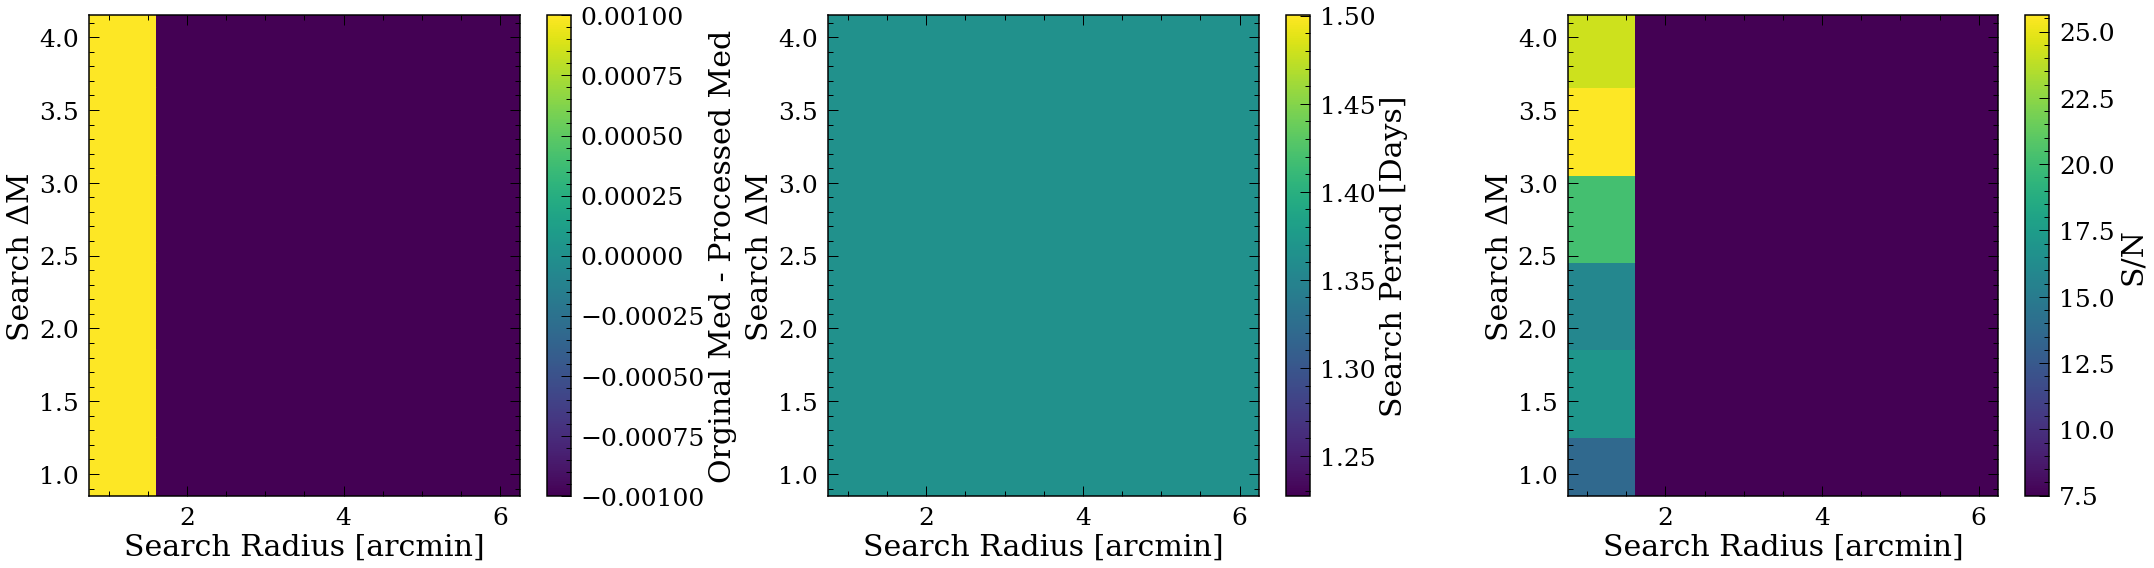

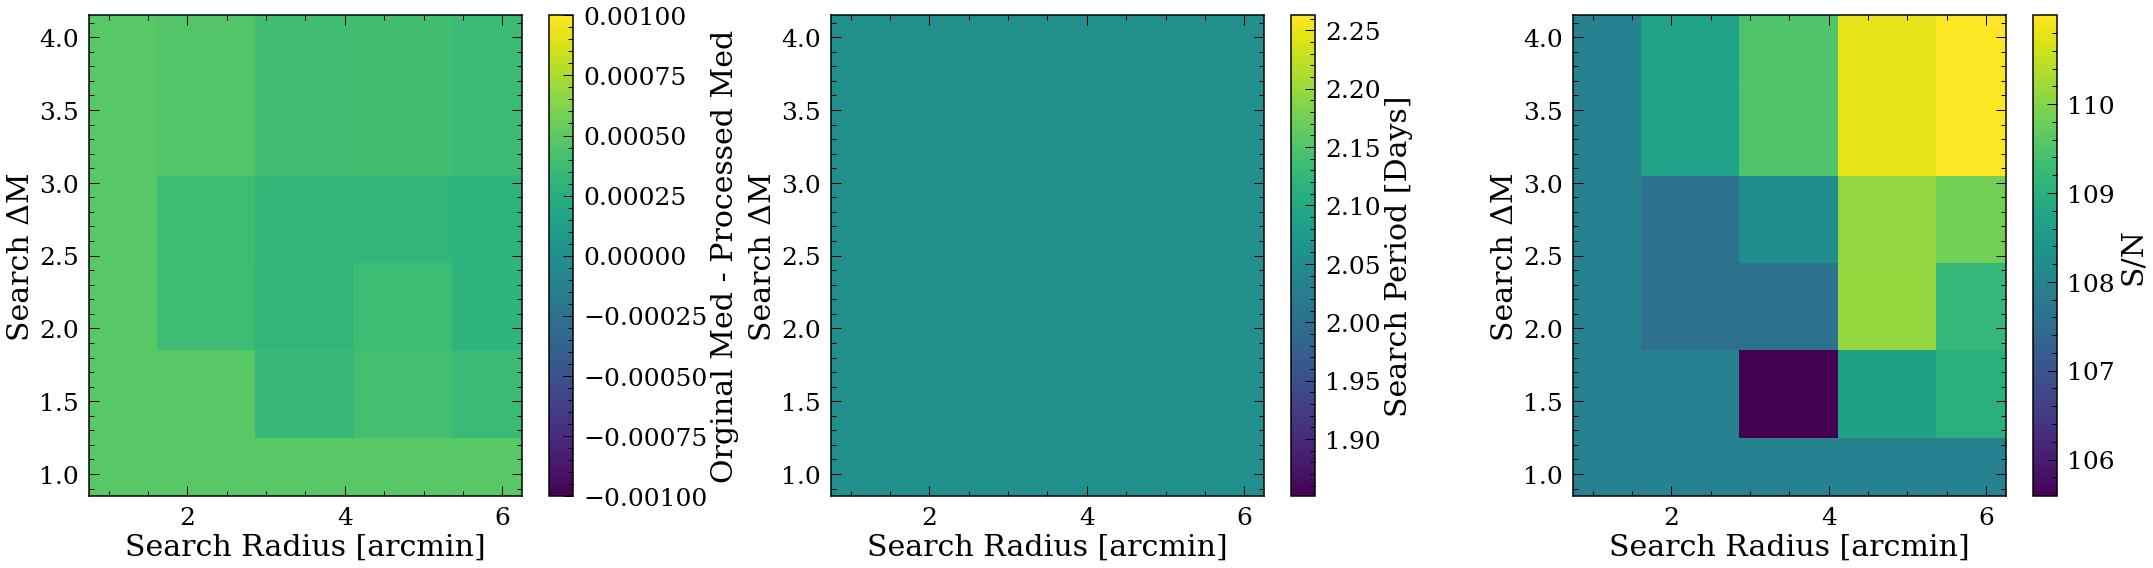

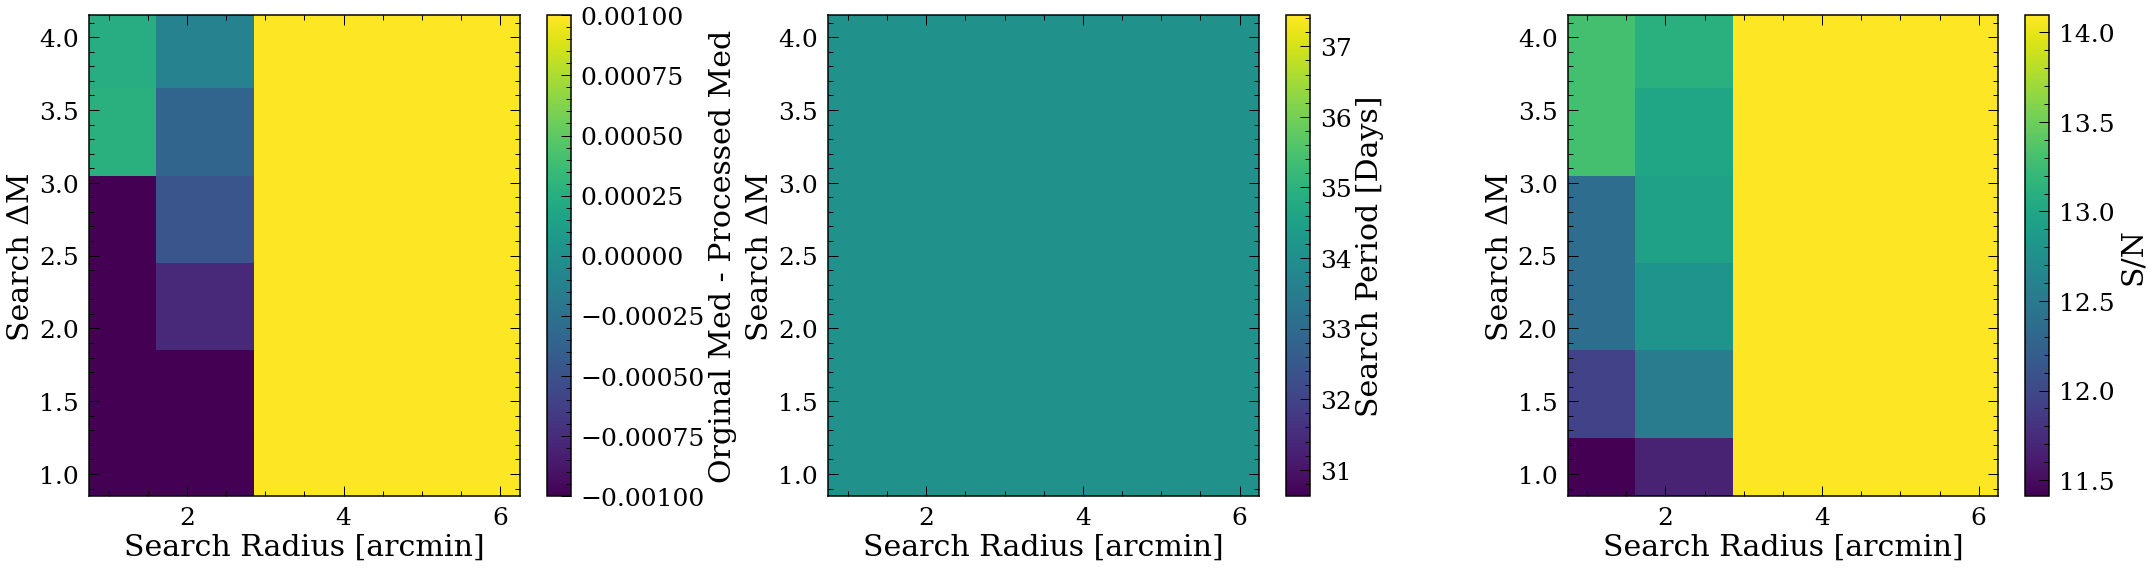

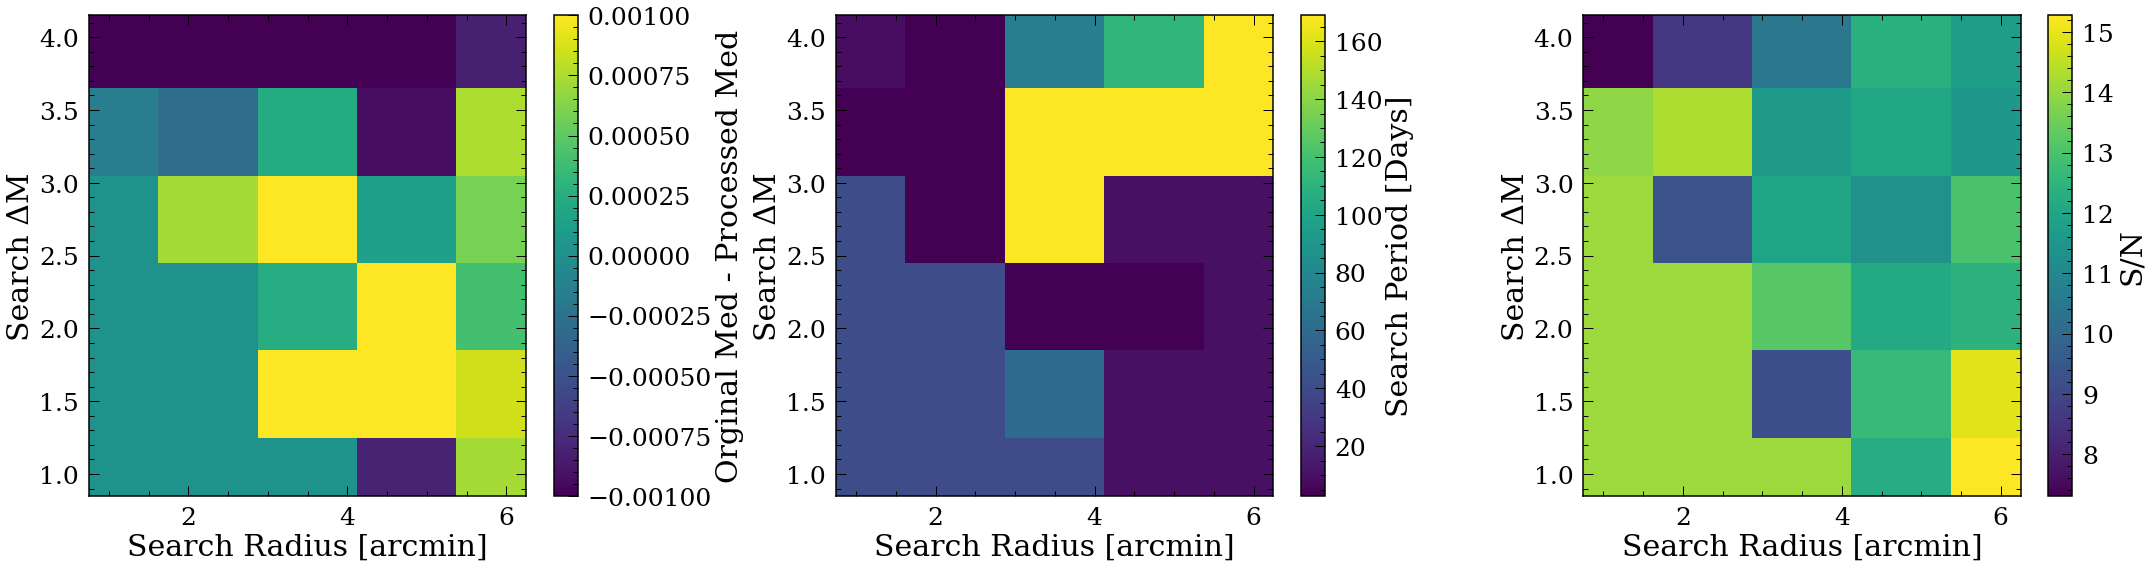

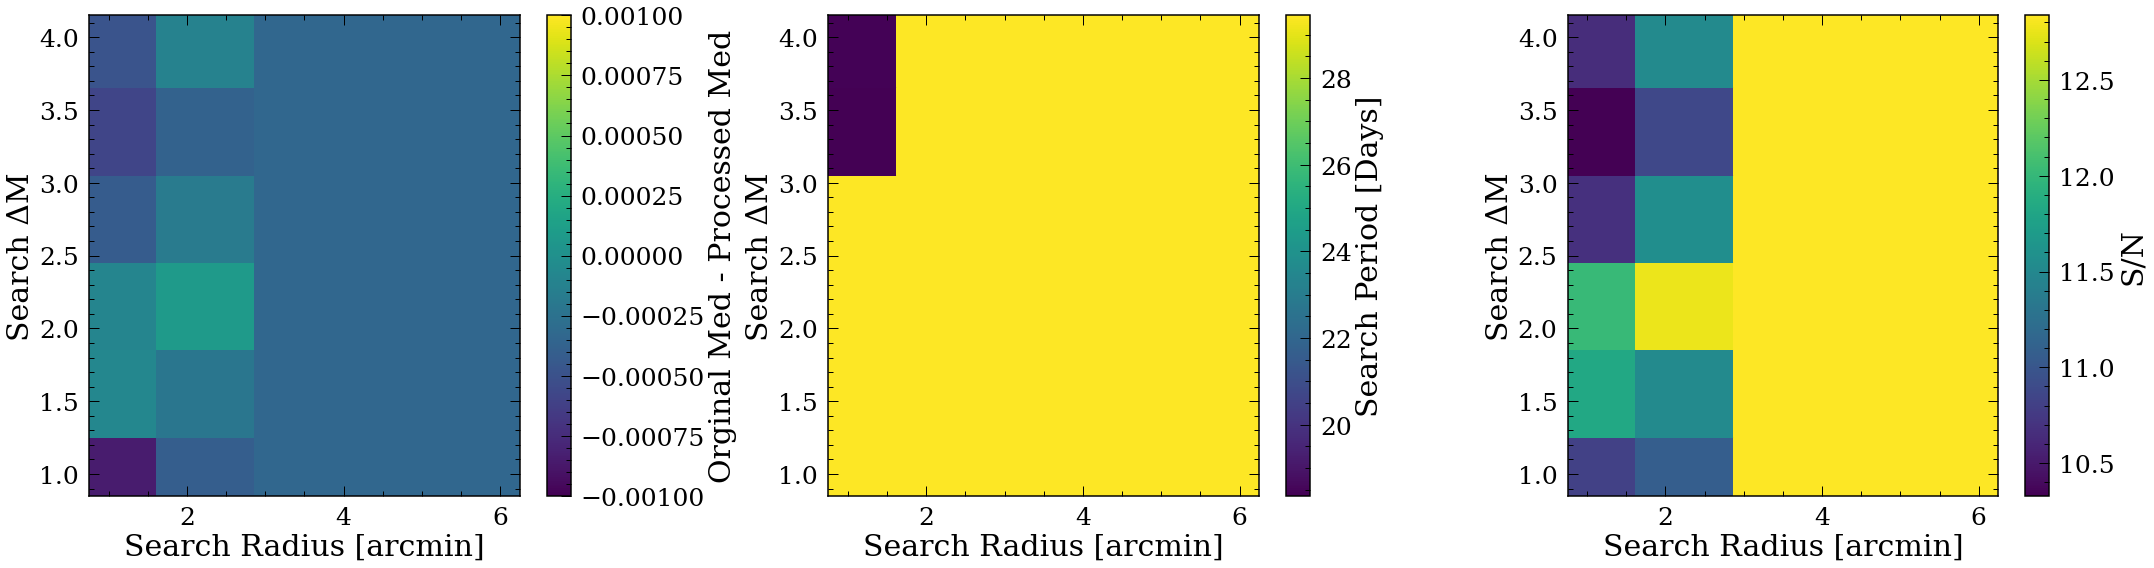

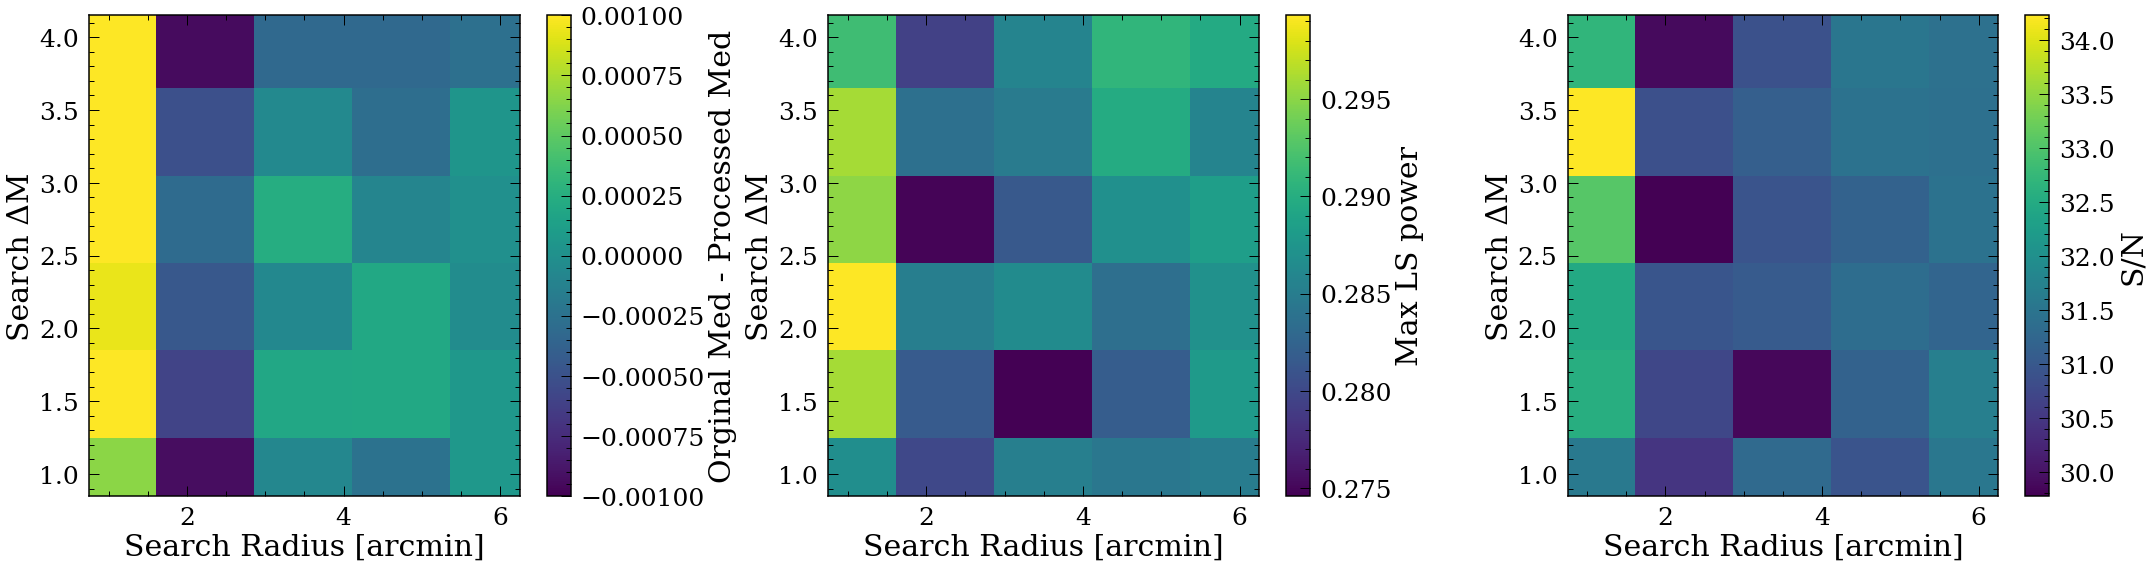

In [773]:
avemedde = np.zeros(len(magsearches[0]))
avemaxls = np.zeros(len(maxpowers[0]))
aveSN = np.zeros(len(maxpowers[0]))

for i in trange(teststars):
    plt.figure(figsize=(30,8))
    plt.subplot(1,3,1)
    plt.scatter(radsearches[i], magsearches[i], c=medorpowers[i]-medpowers[i],
               s=10000, marker='s',vmin=-0.001,vmax=0.001)
    plt.xlabel('Search Radius [arcmin]')
    plt.ylabel('Search ΔM')
    cb = plt.colorbar()
    cb.set_label('Orginal Med - Processed Med')
    
    plt.subplot(1,3,2)
    plt.scatter(radsearches[i], magsearches[i], c=allprots[i],
               s=10000, marker='s')
    plt.xlabel('Search Radius [arcmin]')
    plt.ylabel('Search ΔM')
    cb = plt.colorbar()
    cb.set_label('Search Period [Days]')
    plt.tight_layout()
    
    plt.subplot(1,3,3)
    plt.scatter(radsearches[i], magsearches[i], c=maxpowers[i]/medpowers[i],
               s=10000, marker='s')
    plt.xlabel('Search Radius [arcmin]')
    plt.ylabel('Search ΔM')
    cb = plt.colorbar()
    cb.set_label('S/N')
    plt.tight_layout()
    
    avemedde = avemedde+medorpowers[i]-medpowers[i]
    avemaxls = avemaxls+maxpowers[i]
    aveSN = aveSN+maxpowers[i]/medpowers[i]
    
avemedde, avemaxls, aveSN = avemedde/5, avemaxls/5, aveSN/5

plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.scatter(radsearches[i], magsearches[i], c=avemedde,
           s=10000, marker='s',vmin=-0.001,vmax=0.001)
plt.xlabel('Search Radius [arcmin]')
plt.ylabel('Search ΔM')
cb = plt.colorbar()
cb.set_label('Orginal Med - Processed Med')

plt.subplot(1,3,2)
plt.scatter(radsearches[i], magsearches[i], c=avemaxls,
           s=10000, marker='s')
plt.xlabel('Search Radius [arcmin]')
plt.ylabel('Search ΔM')
cb = plt.colorbar()
cb.set_label('Max LS power')
plt.tight_layout()

plt.subplot(1,3,3)
plt.scatter(radsearches[i], magsearches[i], c=aveSN,
           s=10000, marker='s')
plt.xlabel('Search Radius [arcmin]')
plt.ylabel('Search ΔM')
cb = plt.colorbar()
cb.set_label('S/N')
plt.tight_layout()


# Check periods after folding

In [965]:
def pf(ids, P):
    star_name = "2MASS "+ids
    c = SkyCoord.from_name(star_name, frame='icrs')
    mainlc = download_ztf_archive_lightcurves(c.ra.deg, c.dec.deg, sr=0.001, 
                                              lcout=True)
    
    mainlc = mainlc.loc[mainlc['oid']==mainlc['oid'][0]].reset_index(drop=True)
    mainlc = mainlc.dropna(subset=['mjd','mag','magerr']).reset_index(drop=True)
    mainlc = mainlc[['oid','mjd','mag','magerr']]
    lctime = mainlc.mjd.values
    lcmags = mainlc.mag.values
    
    t_fold=(lctime-np.median(lctime))-np.round((lctime-np.median(lctime))/P)*P
    
    plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    plt.plot(lctime,  lcmags, 'ko')   
    plt.subplot(1,2,2)
    plt.plot(t_fold,  lcmags, 'ko')   

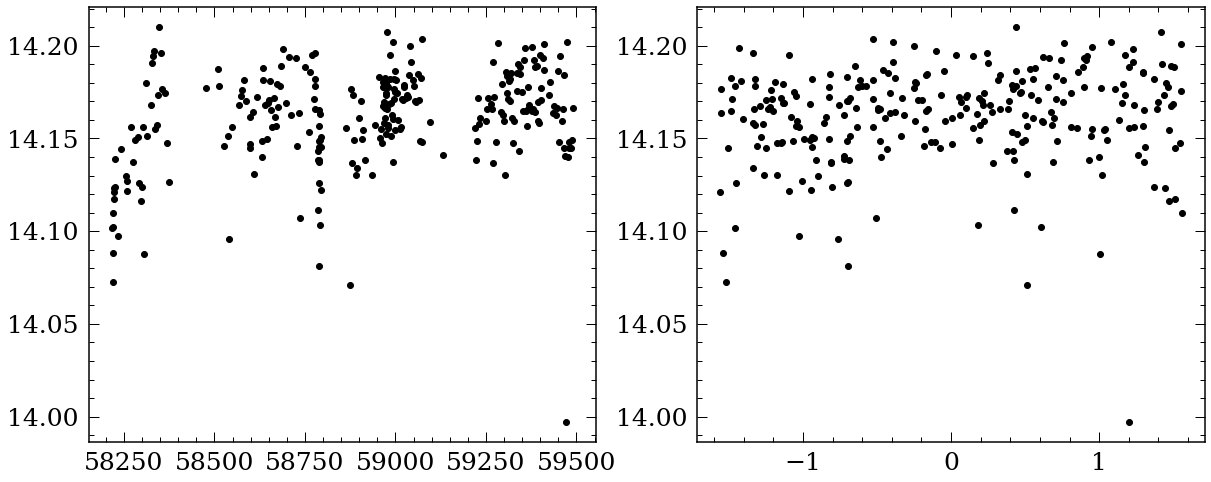

In [1005]:
pf('J16041322+2331386',3.12)

# possible to get period?


In [1006]:

idinc = ['J00240376+2626299', 'J00304867+7742338','J00355322+5241123','J01192628+5450382',
        'J02271705+5432479','J02364412+2240265','J02514973+2929131','J03223165+2858291',
        'J03304890+5413551','J03364083+0329194','J03360868+3118398','J03425325+2326495',
        'J04123491+3529592','J04302527+3951000','J04434430+1505565','J04523448+4042255',
        'J05030563+2122362','J05532295+2212500','J06073185+4712266','J06363696+0619102',
        'J06405810+4944304','J06444751+1628181','J07170893+4545542','J07312949+0249084',
        'J07374384+0554368','J07454039+4931488','J08373021+0333458','J08595559+0610052',
        'J09182301+6037310','J09264503+0857421','J09585650+0558000','J10564633+3246278',
        'J10574650+0453319','J11052425+5005414','J11124232+7626563','J13022083+3227103',
        'J13155111+4006086','J14224340+1624464','J14311348+7526423','J14321078+1600494',
        'J15474070+2241165','J16041322+2331386','J16191111+0140411','J17335314+1655129',
        'J18133315+0532118','J18130657+2601519','J18315610+7730367','J18424498+1354168',
        'J18452147+0711584','J18452294+1851585','J19311257+3607300','J20414744+4938482',
        'J20515794+5922481','J21013344+3957037','J21381698+5257188','J22232904+3227334',
        'J22523963+7504190','J23025250+4338157','J04485783+3648237','J05405390+0854183',
        'J05553087+0124118','J06481555+0326243','J07302916+6247270','J07385081+1829205',
        'J08351992+1408333','J08571541+1924177','J10030191+3433197','J10211908+0804268',
        'J11005043+1204108','J14231683+1318096','J14305591+0858023','J15421432+6533122',
        'J17164779+1133523','J18081215+1134467','J18144837+7843103','J19505984+2009559',
        'J20434307+5509469','J21100351+6615021','J23270216+2710367','J10265964+5506530']
idinc = np.array(idinc)
print(len(idinc))


possbi = ['y', 'imp', 'imp', 'y', 
          'y', 'imp','imp','y',
          'y','imp','imp','imp',
          'imp','imp','?','imp',
          '?','imp','?','ztf',
          'imp','y','?','ztf',
          'imp','?', 'y','y',
          'ztf','ztf','imp','y',
          'imp','y','y','imp',
          'y','?','ztf','ztf',
          'y','imp','y','?',
          'imp','imp','y','imp',
          'imp','imp','y','imp',
         'imp','y','imp','imp',
          'imp','ztf','imp','imp',
          'imp','imp','y','imp',
         'ztf','y','?','imp',
          'y','ztf','y','y',
          '?','imp','imp','imp',
          'imp','ztf','?','imp']
possbi = np.array(possbi)
print(len(possbi))
print(sum(possbi=='ztf'))


eyecheck = pd.DataFrame(np.array((idinc, possbi)).T, columns=['2MASS','poss'])

80
80
10


# check run time

In [288]:
runtimes = pd.read_table('ztfProts', delimiter=',')
runtimes

,id,prot,dt,pt
0,J00240376+2626299,117.075790,182.597601,9.937672
1,J00304867+7742338,388.409282,199.568209,7.552871
2,J00355322+5241123,0.999551,371.697443,232.127325
3,J01192628+5450382,598.463327,288.316492,11.185638
4,J02271705+5432479,1.411739,605.306482,1.527099
...,...,...,...,...
126,J20434307+5509469,1.080409,849.362183,1.456243
127,J20434307+5509469,306.042201,839.492823,1.675180
128,J20434307+5509469,2.653215,830.555510,1.636672
129,J21100351+6615021,95.234123,333.429205,86.520655


In [296]:
runtimes['tt'] = runtimes['dt']+runtimes['pt']
#runtimes['tt'].hist(bins=np.linspace(0,1000,100))
#runtimes['dt'].hist(bins=np.linspace(0,1000,100))
#runtimes['pt'].hist(bins=np.linspace(0,1000,100))

In [298]:
np.median(runtimes['tt'])/60

2.68139741619428

# New results from splitting lcs

In [614]:
prots_raw = pd.read_table('ztfProts_split', delimiter=',')

In [495]:

bestid = prots_raw['id'].values
bestprot = np.zeros(len(prots_raw))
maxprot = np.zeros(len(prots_raw))
same2 = np.zeros(len(prots_raw))


In [519]:
for i in trange(len(bestid)):
    prots_sing = prots.loc[prots['id']==bestid[i]]
    oneprot = prots_sing[['prot1','prot2','prot3','prot4','prot5']].dropna(axis=1).values[0]
    maxpowers = prots_sing[['maxpower1','maxpower2','maxpower3','maxpower4','maxpower5']].dropna(axis=1).values[0]
    
    if len(oneprot)<3:
        bestprot[i] = oneprot[maxpowers==max(maxpowers)]
        maxprot[i] = oneprot[maxpowers==max(maxpowers)]
        same2[i]=0
        continue
    oneprot_test = np.append(oneprot, [oneprot[0]])
    smalldiff = min(abs(np.diff(oneprot_test)))
    m2 = (abs(np.diff(oneprot_test))==min(abs(np.diff(oneprot_test))))
    m2 = np.append(m2,[False])
    if smalldiff/oneprot_test[m2]<0.05:
        bestprot[i]=oneprot_test[m2]
        same2[i]=1
    else:
        bestprot[i] = oneprot[maxpowers==max(maxpowers)]
        same2[i]=0
    maxprot[i] = oneprot[maxpowers==max(maxpowers)]
    
    

100%|██████████| 82/82 [00:00<00:00, 323.55it/s]


In [520]:
prots = pd.DataFrame(np.array((bestid, bestprot,maxprot,same2)).T, 
                     columns = ['2MASS', 'Prot_best','Prot_all','same_inx'])


In [521]:
df_cm = pd.merge(radec[['2MASS','P']], prots, left_on='2MASS', right_on='2MASS', how='inner')
df_cm = df_cm.drop_duplicates(subset=['2MASS'], keep='first')



In [522]:
from astroquery.gaia import Gaia
radius = u.Quantity(0.003, u.deg)
ids = df_cm['2MASS'].values
Gaia.ROW_LIMIT = 1
mags = np.zeros(len(df_cm))*np.nan
for i in trange(len(df_cm)):
    star_name = "2MASS "+ids[i]
    c = SkyCoord.from_name(star_name, frame='icrs')
    j = Gaia.cone_search_async(c, radius)
    r = j.get_results()
    try:
        mags[i] = r['phot_g_mean_mag'].value.data[0]
    except:
        continue

  1%|          | 1/82 [00:01<02:28,  1.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
  2%|▏         | 2/82 [00:03<02:03,  1.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
  4%|▎         | 3/82 [00:04<01:55,  1.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
  5%|▍         | 4/82 [00:05<01:49,  1.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
  6%|▌         | 5/82 [00:07<01:46,  1.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
  7%|▋         | 6/82 [00:08<01:43,  1.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
  9%|▊         | 7/82 [00:09<01:41,  1.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 10%|▉         | 8/82 [00:11<01:40,  1.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 11%|█         | 9/82 [00:12<01:38,  1.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 12%|█▏        | 10/82 [00:13<01:36,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 13%|█▎        | 11/82 [00:15<01:35,  1.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 15%|█▍        | 12/82 [00:16<01:41,  1.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 16%|█▌        | 13/82 [00:18<01:36,  1.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 17%|█▋        | 14/82 [00:19<01:33,  1.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 18%|█▊        | 15/82 [00:20<01:31,  1.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 20%|█▉        | 16/82 [00:22<01:29,  1.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 21%|██        | 17/82 [00:23<01:27,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 22%|██▏       | 18/82 [00:24<01:25,  1.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 23%|██▎       | 19/82 [00:26<01:23,  1.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 24%|██▍       | 20/82 [00:27<01:22,  1.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 26%|██▌       | 21/82 [00:28<01:20,  1.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 27%|██▋       | 22/82 [00:30<01:19,  1.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 28%|██▊       | 23/82 [00:31<01:17,  1.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 29%|██▉       | 24/82 [00:32<01:16,  1.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 30%|███       | 25/82 [00:34<01:16,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 32%|███▏      | 26/82 [00:35<01:14,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 33%|███▎      | 27/82 [00:36<01:13,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 34%|███▍      | 28/82 [00:38<01:12,  1.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 35%|███▌      | 29/82 [00:39<01:10,  1.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 37%|███▋      | 30/82 [00:40<01:09,  1.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 38%|███▊      | 31/82 [00:42<01:08,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 39%|███▉      | 32/82 [00:43<01:07,  1.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 40%|████      | 33/82 [00:44<01:06,  1.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 41%|████▏     | 34/82 [00:46<01:04,  1.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 43%|████▎     | 35/82 [00:47<01:02,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 44%|████▍     | 36/82 [00:48<01:01,  1.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 45%|████▌     | 37/82 [00:50<00:59,  1.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 46%|████▋     | 38/82 [00:51<00:58,  1.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 48%|████▊     | 39/82 [00:52<00:56,  1.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 49%|████▉     | 40/82 [00:54<00:55,  1.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 50%|█████     | 41/82 [00:55<00:53,  1.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 51%|█████     | 42/82 [00:56<00:53,  1.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 52%|█████▏    | 43/82 [00:58<00:51,  1.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 54%|█████▎    | 44/82 [01:03<01:38,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 55%|█████▍    | 45/82 [01:05<01:22,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 56%|█████▌    | 46/82 [01:06<01:10,  1.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 57%|█████▋    | 47/82 [01:07<01:01,  1.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 59%|█████▊    | 48/82 [01:09<00:55,  1.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 60%|█████▉    | 49/82 [01:10<00:51,  1.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 61%|██████    | 50/82 [01:11<00:47,  1.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 62%|██████▏   | 51/82 [01:13<00:44,  1.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 63%|██████▎   | 52/82 [01:14<00:42,  1.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 65%|██████▍   | 53/82 [01:15<00:40,  1.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 66%|██████▌   | 54/82 [01:17<00:38,  1.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 67%|██████▋   | 55/82 [01:18<00:37,  1.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 68%|██████▊   | 56/82 [01:19<00:35,  1.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 70%|██████▉   | 57/82 [01:21<00:34,  1.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 71%|███████   | 58/82 [01:22<00:32,  1.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 72%|███████▏  | 59/82 [01:23<00:31,  1.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 73%|███████▎  | 60/82 [01:25<00:29,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 74%|███████▍  | 61/82 [01:26<00:27,  1.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 76%|███████▌  | 62/82 [01:27<00:26,  1.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 77%|███████▋  | 63/82 [01:29<00:25,  1.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 78%|███████▊  | 64/82 [01:30<00:24,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 79%|███████▉  | 65/82 [01:31<00:22,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 80%|████████  | 66/82 [01:33<00:21,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 82%|████████▏ | 67/82 [01:34<00:20,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 83%|████████▎ | 68/82 [01:35<00:18,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 84%|████████▍ | 69/82 [01:37<00:17,  1.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 85%|████████▌ | 70/82 [01:38<00:16,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 87%|████████▋ | 71/82 [01:39<00:14,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 88%|████████▊ | 72/82 [01:41<00:13,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 89%|████████▉ | 73/82 [01:42<00:12,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 90%|█████████ | 74/82 [01:43<00:10,  1.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 91%|█████████▏| 75/82 [01:45<00:09,  1.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 93%|█████████▎| 76/82 [01:46<00:08,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 94%|█████████▍| 77/82 [01:47<00:06,  1.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 95%|█████████▌| 78/82 [01:49<00:05,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 96%|█████████▋| 79/82 [01:50<00:04,  1.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 98%|█████████▊| 80/82 [01:51<00:02,  1.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
 99%|█████████▉| 81/82 [01:53<00:01,  1.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
100%|██████████| 82/82 [01:54<00:00,  1.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


In [523]:
df_cm['gmag'] = mags

21 0.25609756097560976
14 0.35


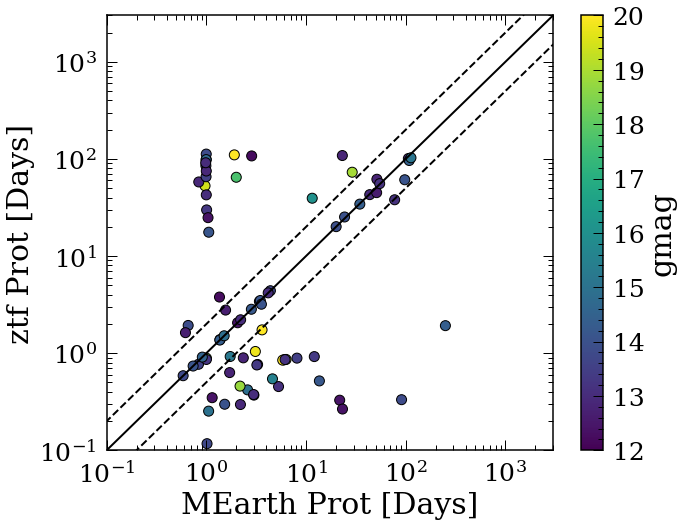

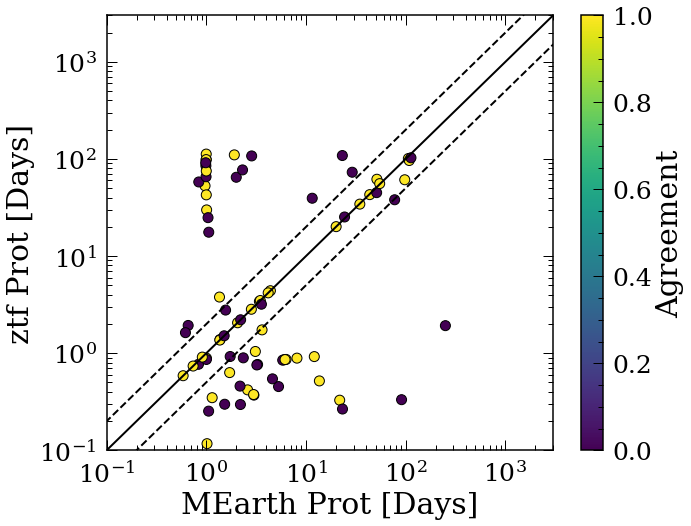

In [553]:
plt.figure(figsize=(10,8))
plt.scatter(df_cm['Prot_best'], df_cm['P'], c=df_cm['gmag'], s=100, 
            edgecolor='k', vmin=12, vmax=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,3000], [0,3000], 'k-')
plt.plot([0,3000], [0,6000], 'k--')
plt.plot([0,6000], [0,3000], 'k--')
plt.xlim([0.1,3000])
plt.ylim([0.1,3000])
cb = plt.colorbar()


goodp = (abs(df_cm['Prot_best']-df_cm['P'])/df_cm['P'])<0.1
goodp = np.array(goodp, dtype=int)
df_cm['agreement'] = goodp
print(sum(goodp), sum((abs(df_cm['Prot_best']-df_cm['P'])/df_cm['P'])<0.1)/len(df_cm))


cb.set_label('gmag')

plt.figure(figsize=(10,8))
plt.scatter(df_cm['Prot_best'], df_cm['P'], c=df_cm['same_inx'], s=100, 
            edgecolor='k', vmin=0, vmax=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,3000], [0,3000], 'k-')
plt.plot([0,3000], [0,6000], 'k--')
plt.plot([0,6000], [0,3000], 'k--')
plt.xlim([0.1,3000])
plt.ylim([0.1,3000])
cb = plt.colorbar()
cb.set_label('Agreement')

df_cm_good = df_cm.loc[df_cm['same_inx']==1]
goodp = (abs(df_cm_good['Prot_all']-df_cm_good['P'])/df_cm_good['P'])<0.1
print(sum(goodp), sum((abs(df_cm_good['Prot_all']-df_cm_good['P'])/df_cm_good['P'])<0.1)/len(df_cm_good))



20 0.24390243902439024
14 0.35


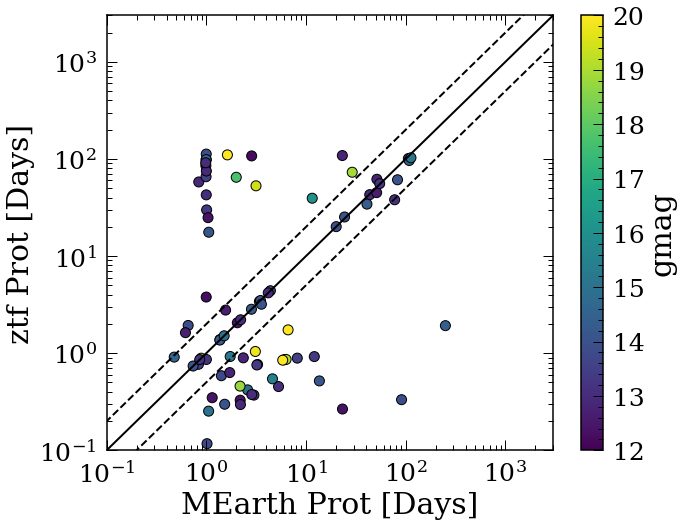

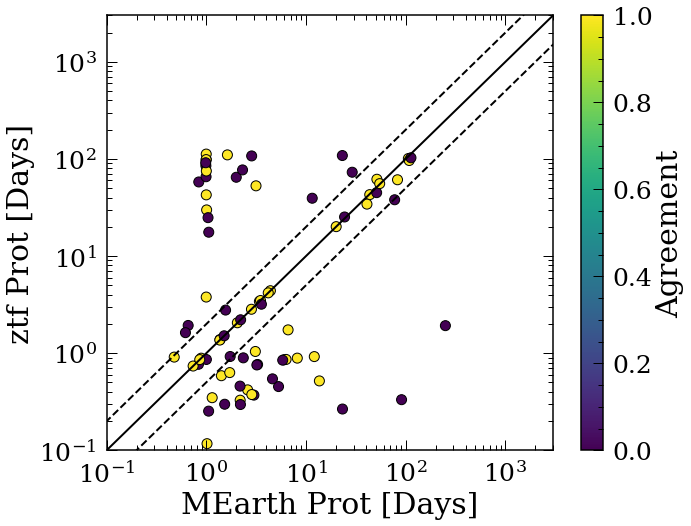

In [558]:
plt.figure(figsize=(10,8))
plt.scatter(df_cm['Prot_all'], df_cm['P'], c=df_cm['gmag'], s=100, 
            edgecolor='k', vmin=12, vmax=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,3000], [0,3000], 'k-')
plt.plot([0,3000], [0,6000], 'k--')
plt.plot([0,6000], [0,3000], 'k--')
plt.xlim([0.1,3000])
plt.ylim([0.1,3000])
cb = plt.colorbar()
cb.set_label('gmag')

goodp = (abs(df_cm['Prot_all']-df_cm['P'])/df_cm['P'])<0.1
print(sum(goodp), sum((abs(df_cm['Prot_all']-df_cm['P'])/df_cm['P'])<0.1)/len(df_cm))

plt.figure(figsize=(10,8))
plt.scatter(df_cm['Prot_all'], df_cm['P'], c=df_cm['same_inx'], s=100, 
            edgecolor='k', vmin=0, vmax=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,3000], [0,3000], 'k-')
plt.plot([0,3000], [0,6000], 'k--')
plt.plot([0,6000], [0,3000], 'k--')
plt.xlim([0.1,3000])
plt.ylim([0.1,3000])
cb = plt.colorbar()
cb.set_label('Agreement')

df_cm_good = df_cm.loc[df_cm['same_inx']==1]
goodp = (abs(df_cm_good['Prot_all']-df_cm_good['P'])/df_cm_good['P'])<0.1
print(sum(goodp), sum((abs(df_cm_good['Prot_all']-df_cm_good['P'])/df_cm_good['P'])<0.1)/len(df_cm_good))



In [570]:
prots_raw = pd.merge(prots_raw, df_cm[['Prot_best','gmag','2MASS','agreement','P']],left_on='id', right_on='2MASS', how='inner')


In [571]:
sum(prots_raw['agreement'])

21

40 0.4878048780487805


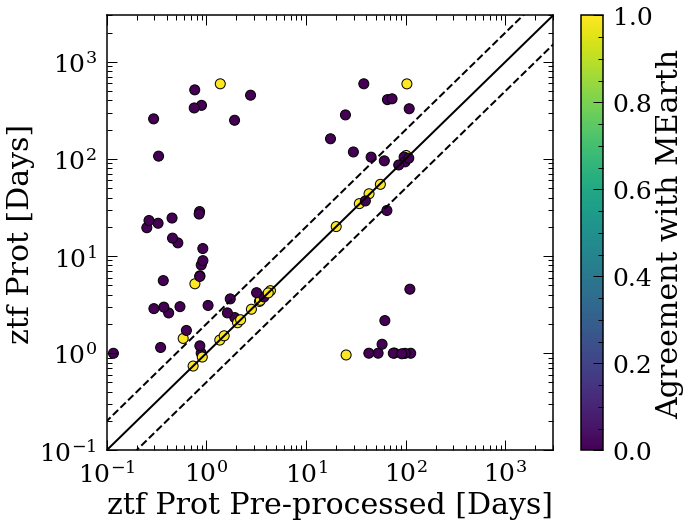

In [585]:
plt.figure(figsize=(10,8))
plt.scatter(prots_raw['P'], prots_raw['prot1'], c=prots_raw['agreement'], s=100, 
            edgecolor='k', vmin=0, vmax=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('ztf Prot Pre-processed [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,3000], [0,3000], 'k-')
plt.plot([0,3000], [0,6000], 'k--')
plt.plot([0,6000], [0,3000], 'k--')
plt.xlim([0.1,3000])
plt.ylim([0.1,3000])
cb = plt.colorbar()
cb.set_label('Agreement with MEarth')

prots_raw['overall1'] = (abs(prots_raw['prot1']-prots_raw['P'])/prots_raw['P'])<0.1
prots_raw['overall2'] = (abs(prots_raw['prot2']-prots_raw['P'])/prots_raw['P'])<0.1
prots_raw['overall3'] = (abs(prots_raw['prot3']-prots_raw['P'])/prots_raw['P'])<0.1
prots_raw['overall4'] = (abs(prots_raw['prot4']-prots_raw['P'])/prots_raw['P'])<0.1
prots_raw['overall5'] = (abs(prots_raw['prot5']-prots_raw['P'])/prots_raw['P'])<0.1
goodp = (abs(prots_raw['prot1']-prots_raw['P'])/prots_raw['P'])<0.1
goodp = goodp|((abs(prots_raw['prot2']-prots_raw['P'])/prots_raw['P'])<0.1)
goodp = goodp|((abs(prots_raw['prot3']-prots_raw['P'])/prots_raw['P'])<0.1)
goodp = goodp|((abs(prots_raw['prot4']-prots_raw['P'])/prots_raw['P'])<0.1)
goodp = goodp|((abs(prots_raw['prot5']-prots_raw['P'])/prots_raw['P'])<0.1)
prots_raw['overall'] = goodp
print(sum(goodp), sum(goodp)/len(prots_raw))





In [608]:
gaia = pd.read_csv('MEarth_Rotator_List_v2.csv')
prots_raw = pd.merge(prots_raw, gaia[['2MASS','Ignore']], left_on='2MASS', right_on='2MASS')


In [611]:
sum(prots_raw['Ignore']==1)

7

40 82 0.4878048780487805


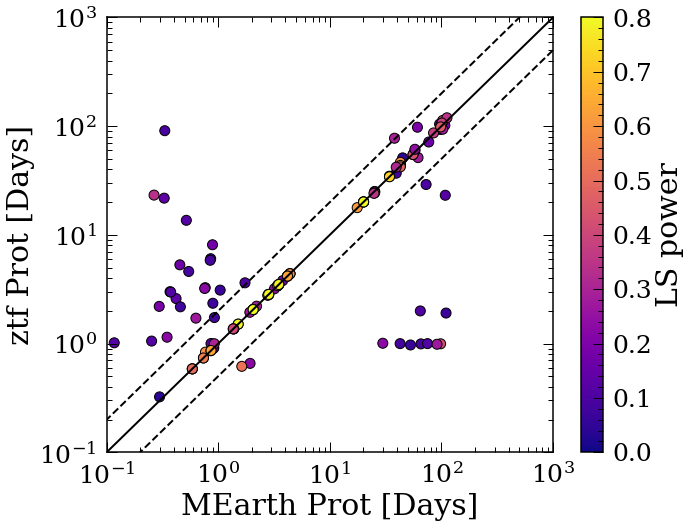

In [612]:
import matplotlib.colors
def getcolor(vrange,cm=plt.cm.get_cmap('jet')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    return [cmap(norm(i)) for i in vrange]
colors = getcolor(np.array([1,2,3,4,5,6]),plt.cm.get_cmap('plasma'))

cmap = plt.cm.get_cmap('plasma')
plt.figure(figsize=(10,8))
prots_pag = prots_raw.loc[prots_raw['overall']==0]
plt.scatter(prots_pag['P'], prots_pag['Prot_best'], c=prots_pag['maxpower1'], s=100, 
                edgecolor='k', cmap=cmap, vmin=0, vmax=0.8)
print(sum(prots_raw['overall']==1), len(prots_raw), sum(prots_raw['overall']==1)/len(prots_raw))

for i in range(1,6):
    prots_pag = prots_raw.loc[prots_raw['overall'+str(i)]==1]
    plt.scatter(prots_pag['P'], prots_pag['prot'+str(i)], 
                c=prots_pag['maxpower'+str(i)], s=100, 
                edgecolor='k', label='At least one season agrees', 
                cmap=cmap, vmin=0, vmax=0.8)
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,1000], [0,1000], 'k-')
plt.plot([0,1000], [0,2000], 'k--')
plt.plot([0,2000], [0,1000], 'k--')
plt.xlim([0.1,1000])
plt.ylim([0.1,1000])

cb = plt.colorbar()
cb.set_label('LS power')



38 0.5066666666666667


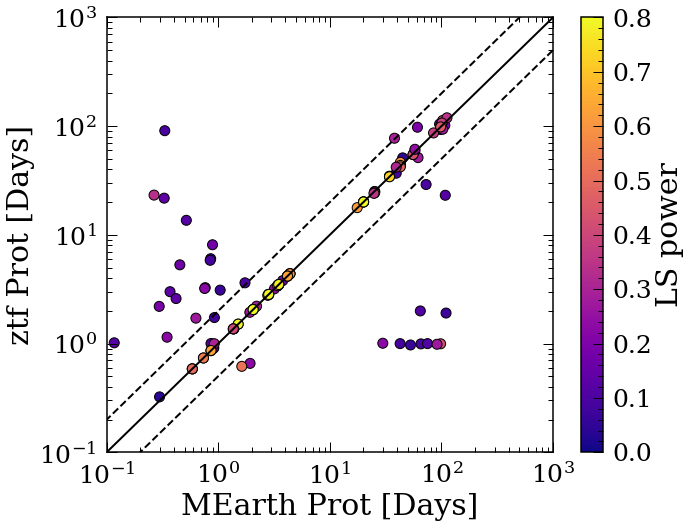

In [610]:
# only do the ones Jason said we should for ztf
import matplotlib.colors
prots_raw_sort = prots_raw.loc[prots_raw['Ignore']==0].reset_index(drop=True)

cmap = plt.cm.get_cmap('plasma')
plt.figure(figsize=(10,8))
prots_pag = prots_raw_sort.loc[prots_raw_sort['overall']==0]
plt.scatter(prots_pag['P'], prots_pag['Prot_best'], c=prots_pag['maxpower1'], s=100, 
                edgecolor='k', cmap=cmap, vmin=0, vmax=0.8)
print(sum(prots_raw_sort['overall']==1), sum(prots_raw_sort['overall']==1)/len(prots_raw_sort))

for i in range(1,6):
    prots_pag = prots_raw_sort.loc[prots_raw_sort['overall'+str(i)]==1]
    plt.scatter(prots_pag['P'], prots_pag['prot'+str(i)], 
                c=prots_pag['maxpower'+str(i)], s=100, 
                edgecolor='k', label='At least one season agrees', 
                cmap=cmap, vmin=0, vmax=0.8)
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,1000], [0,1000], 'k-')
plt.plot([0,1000], [0,2000], 'k--')
plt.plot([0,2000], [0,1000], 'k--')
plt.xlim([0.1,1000])
plt.ylim([0.1,1000])

cb = plt.colorbar()
cb.set_label('LS power')




14 0.35


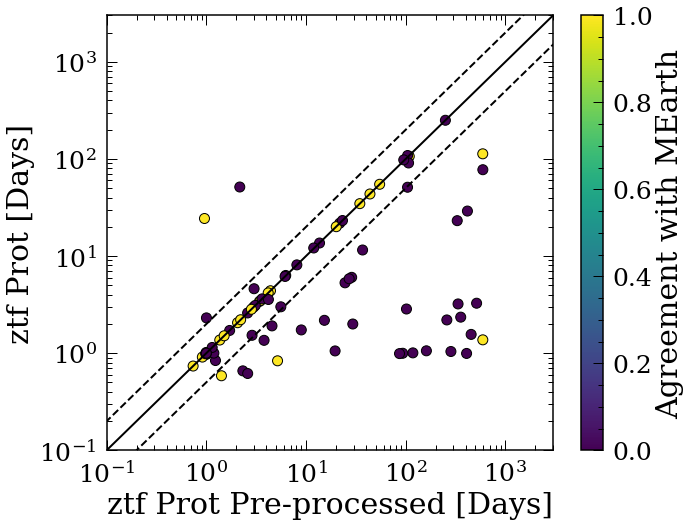

In [566]:
plt.figure(figsize=(10,8))
plt.scatter(prots_raw['prot1'], prots_raw['Prot_best'], c=prots_raw['agreement'], s=100, 
            edgecolor='k', vmin=0, vmax=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('ztf Prot Pre-processed [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,3000], [0,3000], 'k-')
plt.plot([0,3000], [0,6000], 'k--')
plt.plot([0,6000], [0,3000], 'k--')
plt.xlim([0.1,3000])
plt.ylim([0.1,3000])
cb = plt.colorbar()
cb.set_label('Agreement with MEarth')

df_cm_good = df_cm.loc[df_cm['same_inx']==1]
goodp = (abs(df_cm_good['Prot_all']-df_cm_good['P'])/df_cm_good['P'])<0.1
print(sum(goodp), sum((abs(df_cm_good['Prot_all']-df_cm_good['P'])/df_cm_good['P'])<0.1)/len(df_cm_good))




# New results from splitting lcs check median power (noise) 

In [635]:
prots_raw = pd.read_table('ztfProts_split_medpower', delimiter=',')


In [636]:
prots_raw

,id,prot1,prot2,prot3,prot4,prot5,prot6,prot7,maxpower1,maxpower2,...,maxpower6,maxpower7,medpower_org,medpower1,medpower2,medpower3,medpower4,medpower5,medpower6,medpower7
0,J00240376+2626299,117.897664,1.507829,126.662600,1.007072,0.996985,NaN,NaN,0.228308,0.378497,...,NaN,NaN,0.005106,0.004747,0.023466,0.021691,0.009599,0.034499,NaN,NaN
1,J00355322+5241123,0.999481,3.150307,0.970686,NaN,NaN,NaN,NaN,0.063962,0.205074,...,NaN,NaN,0.010257,0.012790,0.033085,0.021507,NaN,NaN,NaN,NaN
2,J01192628+5450382,161.124564,17.796037,1.057552,NaN,NaN,NaN,NaN,0.461764,0.612313,...,NaN,NaN,0.025378,0.018834,0.050580,0.027826,NaN,NaN,NaN,NaN
3,J02271705+5432479,1.002596,0.997523,8.093517,0.888559,2.150715,NaN,NaN,0.179787,0.213110,...,NaN,NaN,0.046375,0.065973,0.012218,0.145268,0.012397,0.040838,NaN,NaN
4,J02364412+2240265,5.586660,3.000900,NaN,NaN,NaN,NaN,NaN,0.133778,0.182245,...,NaN,NaN,0.017566,0.011824,0.019363,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,J18144837+7843103,0.999426,1.000592,377.566190,NaN,NaN,NaN,NaN,0.112493,0.139470,...,NaN,NaN,0.003583,0.003410,0.009673,0.004401,NaN,NaN,NaN,NaN
78,J19505984+2009559,0.985686,NaN,NaN,NaN,NaN,NaN,NaN,0.273996,NaN,...,NaN,NaN,0.096138,0.098034,NaN,NaN,NaN,NaN,NaN,NaN
79,J20434307+5509469,0.999319,0.998626,0.336810,2.650873,NaN,NaN,NaN,0.087310,0.212139,...,NaN,NaN,0.002824,0.003219,0.008995,0.004188,0.008115,NaN,NaN,NaN
80,J21100351+6615021,95.502264,82.690075,90.562978,97.716427,NaN,NaN,NaN,0.196350,0.640245,...,NaN,NaN,0.002885,0.002408,0.022868,0.006296,0.005135,NaN,NaN,NaN


In [644]:
for i in range(1,8):
    prots_raw['SN'+str(i)]=prots_raw['maxpower'+str(i)]/prots_raw['medpower'+str(i)]

In [662]:
bestid = prots_raw['id'].values
bestprot = np.zeros(len(prots_raw))
bestsn = np.zeros(len(prots_raw))

In [694]:
for i in trange(len(bestid)):
    prots_sing = prots_raw.iloc[i]
    allsn = np.array([prots_sing['SN'+str(j)] for j in range(1,8)])
    #allsn = np.array([prots_sing['medpower'+str(j)] for j in range(1,8)])
    allsn = allsn[allsn==allsn]
    bestprot[i] = prots_sing['prot'+str(np.argmax(allsn)+1)]
    #bestprot[i] = prots_sing['prot'+str(np.argmin(allsn)+1)]
    bestsn[i] = min(allsn)

100%|██████████| 82/82 [00:00<00:00, 3787.85it/s]


In [695]:
prots_raw['bestprot'] = bestprot
prots_raw['bestSN'] = bestsn

In [696]:
df_cm = pd.merge(radec[['2MASS','P','gmag']], prots_raw, left_on='2MASS', right_on='id', how='inner')


25 82 0.3048780487804878


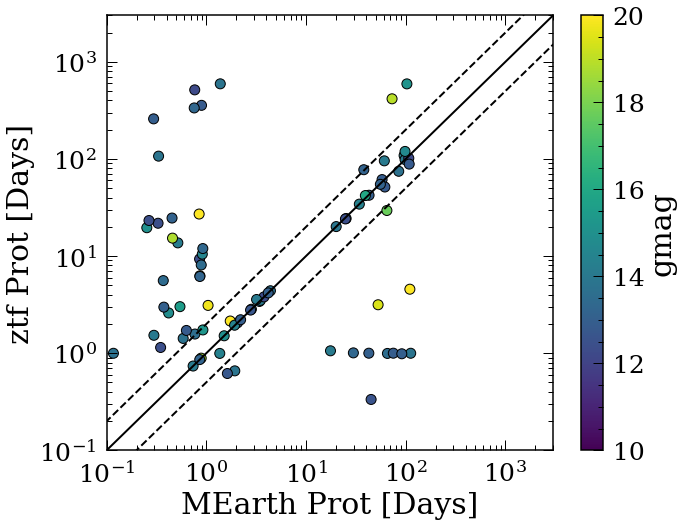

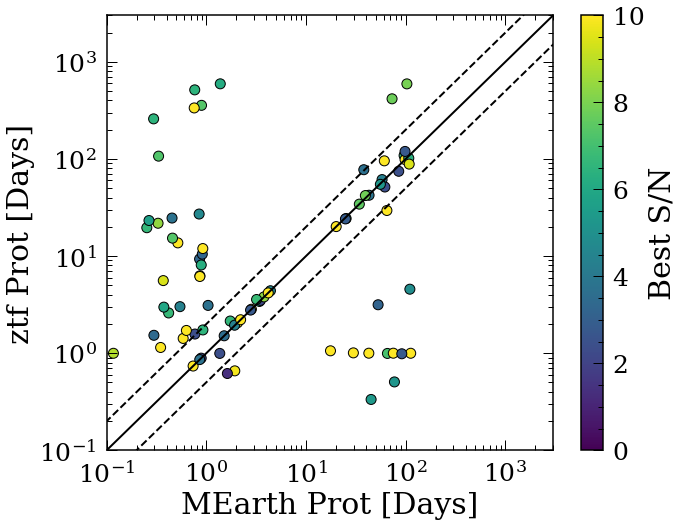

In [698]:
plt.figure(figsize=(10,8))
plt.scatter(df_cm['P'], df_cm['bestprot'], c=df_cm['gmag'], s=100, 
            edgecolor='k', vmin=10, vmax=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,3000], [0,3000], 'k-')
plt.plot([0,3000], [0,6000], 'k--')
plt.plot([0,6000], [0,3000], 'k--')
plt.xlim([0.1,3000])
plt.ylim([0.1,3000])
cb = plt.colorbar()
cb.set_label('gmag')

plt.figure(figsize=(10,8))
plt.scatter(df_cm['P'], df_cm['bestprot'], c=df_cm['bestSN'], s=100, 
            edgecolor='k',vmin=0,vmax=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,3000], [0,3000], 'k-')
plt.plot([0,3000], [0,6000], 'k--')
plt.plot([0,6000], [0,3000], 'k--')
plt.xlim([0.1,3000])
plt.ylim([0.1,3000])
cb = plt.colorbar()
cb.set_label('Best S/N')

goodp = (abs(df_cm['bestprot']-df_cm['P'])/df_cm['P'])<0.1

print(sum(goodp), len(df_cm), sum(goodp)/len(df_cm))

-0.00022985960816994996


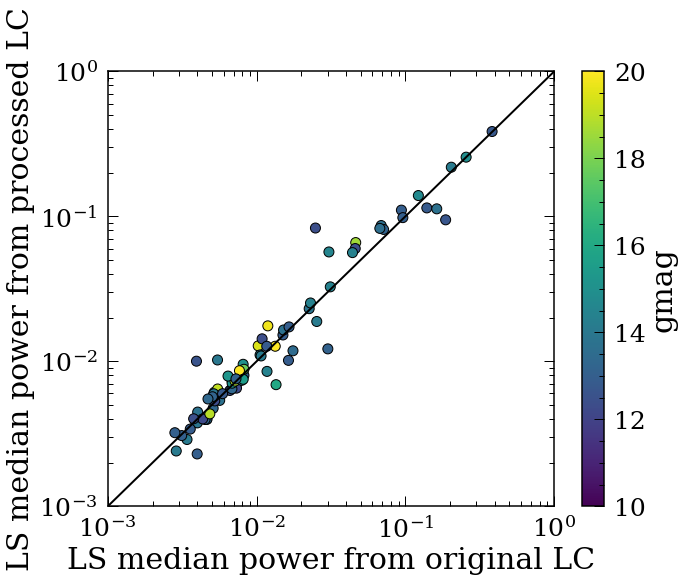

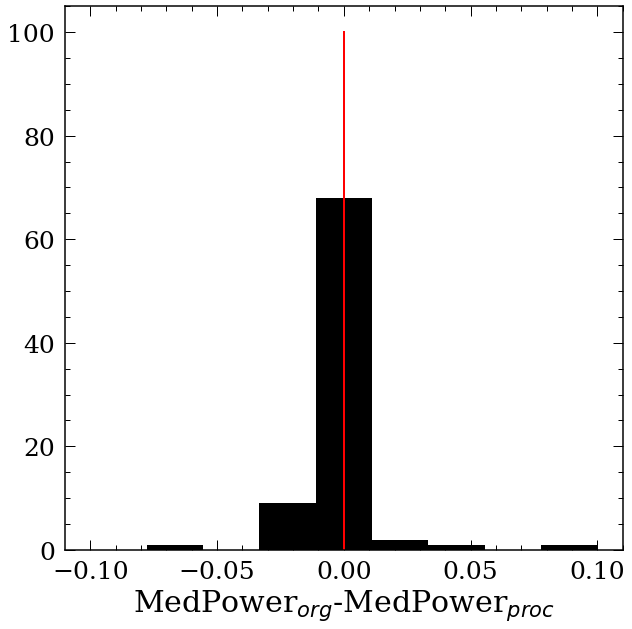

In [782]:
plt.figure(figsize=(10,8))
plt.scatter(df_cm['medpower_org'], df_cm['medpower1'],c=df_cm['gmag'], s=100, 
            edgecolor='k',vmin=10,vmax=20)
plt.plot([0,1], [0,1], 'k-')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-3,1])
plt.ylim([1e-3,1])
plt.xlabel('LS median power from original LC')
plt.ylabel('LS median power from processed LC')
cb = plt.colorbar()
cb.set_label('gmag')

plt.figure()
plt.hist(df_cm['medpower_org']-df_cm['medpower1'],bins=np.linspace(-0.1,0.1,10),
        color='k');
plt.plot([0,0],[0,100],'r-')
plt.xlabel('MedPower$_{org}$-MedPower$_{proc}$')

print(np.median(df_cm['medpower_org']-df_cm['medpower1']))

# Results after quality flag

In [845]:
prots_raw = pd.read_table('ztfProts_split_medpower_qf', delimiter=',')


In [847]:
for i in range(1,8):
    prots_raw['SN'+str(i)]=prots_raw['maxpower'+str(i)]/prots_raw['medpower'+str(i)]
bestid = prots_raw['id'].values
bestprot = np.zeros(len(prots_raw))
bestsn = np.zeros(len(prots_raw))
for i in trange(len(bestid)):
    prots_sing = prots_raw.iloc[i]
    allsn = np.array([prots_sing['SN'+str(j)] for j in range(1,8)])
    #allsn = np.array([prots_sing['medpower'+str(j)] for j in range(1,8)])
    allsn = allsn[allsn==allsn]
    bestprot[i] = prots_sing['prot'+str(np.argmax(allsn)+1)]
    #bestprot[i] = prots_sing['prot'+str(np.argmin(allsn)+1)]
    bestsn[i] = min(allsn)
prots_raw['bestprot'] = bestprot
prots_raw['bestSN'] = bestsn

df_cm = pd.merge(radec[['2MASS','P','gmag']], prots_raw, left_on='2MASS', right_on='id', how='inner')



26 99 0.26262626262626265


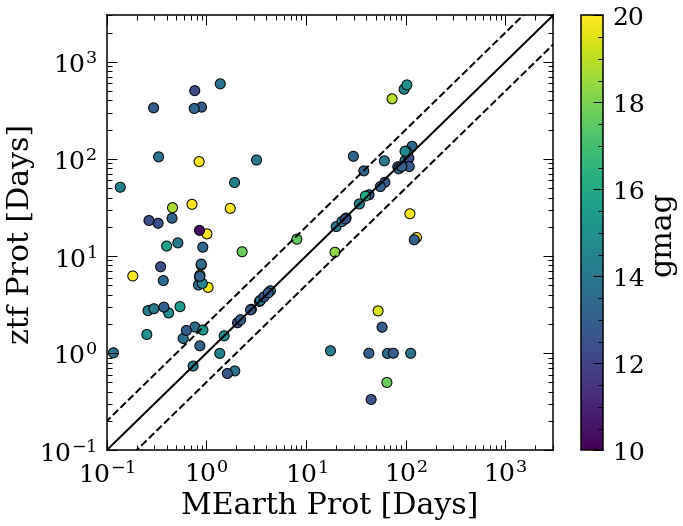

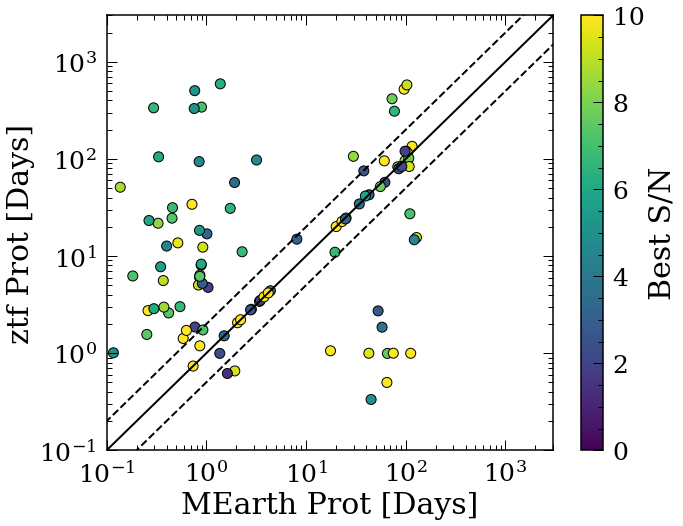

In [851]:
plt.figure(figsize=(10,8))
plt.scatter(df_cm['P'], df_cm['bestprot'], c=df_cm['gmag'], s=100, 
            edgecolor='k', vmin=10, vmax=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,3000], [0,3000], 'k-')
plt.plot([0,3000], [0,6000], 'k--')
plt.plot([0,6000], [0,3000], 'k--')
plt.xlim([0.1,3000])
plt.ylim([0.1,3000])
cb = plt.colorbar()
cb.set_label('gmag')

plt.figure(figsize=(10,8))
plt.scatter(df_cm['P'], df_cm['bestprot'], c=df_cm['bestSN'], s=100, 
            edgecolor='k',vmin=0,vmax=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,3000], [0,3000], 'k-')
plt.plot([0,3000], [0,6000], 'k--')
plt.plot([0,6000], [0,3000], 'k--')
plt.xlim([0.1,3000])
plt.ylim([0.1,3000])
cb = plt.colorbar()
cb.set_label('Best S/N')

goodp = (abs(df_cm['bestprot']-df_cm['P'])/df_cm['P'])<0.1

print(sum(goodp), len(df_cm), sum(goodp)/len(df_cm))

In [1015]:


goodp = (abs(df_cm['bestprot']-df_cm['P'])/df_cm['P'])<0.1

print('Best period:', sum(goodp), len(df_cm), sum(goodp)/len(df_cm))


df_cm['overall1'] = (abs(df_cm['prot1']-df_cm['P'])/df_cm['P'])<0.1
df_cm['overall2'] = (abs(df_cm['prot2']-df_cm['P'])/df_cm['P'])<0.1
df_cm['overall3'] = (abs(df_cm['prot3']-df_cm['P'])/df_cm['P'])<0.1
df_cm['overall4'] = (abs(df_cm['prot4']-df_cm['P'])/df_cm['P'])<0.1
df_cm['overall5'] = (abs(df_cm['prot5']-df_cm['P'])/df_cm['P'])<0.1
df_cm['overall6'] = (abs(df_cm['prot6']-df_cm['P'])/df_cm['P'])<0.1
df_cm['overall7'] = (abs(df_cm['prot7']-df_cm['P'])/df_cm['P'])<0.1
goodp = (abs(df_cm['prot1']-df_cm['P'])/df_cm['P'])<0.1
goodp = goodp|((abs(df_cm['prot2']-df_cm['P'])/df_cm['P'])<0.1)
goodp = goodp|((abs(df_cm['prot3']-df_cm['P'])/df_cm['P'])<0.1)
goodp = goodp|((abs(df_cm['prot4']-df_cm['P'])/df_cm['P'])<0.1)
goodp = goodp|((abs(df_cm['prot5']-df_cm['P'])/df_cm['P'])<0.1)
goodp = goodp|((abs(df_cm['prot6']-df_cm['P'])/df_cm['P'])<0.1)
goodp = goodp|((abs(df_cm['prot7']-df_cm['P'])/df_cm['P'])<0.1)
df_cm['overall'] = goodp
print(sum(df_cm['overall1']),sum(df_cm['overall2']),sum(df_cm['overall3']),
      sum(df_cm['overall4']),sum(df_cm['overall5']),sum(df_cm['overall6']),
     sum(df_cm['overall7']))
print(sum(goodp), sum(goodp)/len(df_cm))



bestid = df_cm['2MASS'].values
bestprot = np.zeros(len(df_cm))
maxprot = np.zeros(len(df_cm))
same2 = np.zeros(len(df_cm))
pstd = np.zeros(len(df_cm))

for i in trange(len(bestid)):
    prots_sing = df_cm.loc[df_cm['2MASS']==bestid[i]]
    oneprot = prots_sing[['prot1','prot2','prot3','prot4','prot5']].dropna(axis=1).values[0]
    maxpowers = prots_sing[['maxpower1','maxpower2','maxpower3','maxpower4','maxpower5']].dropna(axis=1).values[0]
    pstd[i] = np.std(oneprot)/np.mean(oneprot)
    if len(oneprot)<3:
        bestprot[i] = oneprot[maxpowers==max(maxpowers)]
        maxprot[i] = oneprot[maxpowers==max(maxpowers)]
        same2[i]=0
        continue
    oneprot_test = np.append(oneprot, [oneprot[0]])
    smalldiff = min(abs(np.diff(oneprot_test)))
    m2 = (abs(np.diff(oneprot_test))==min(abs(np.diff(oneprot_test))))
    m2 = np.append(m2,[False])
    if smalldiff/oneprot_test[m2]<0.05:
        bestprot[i]=oneprot_test[m2]
        same2[i]=1
    else:
        bestprot[i] = oneprot[maxpowers==max(maxpowers)]
        same2[i]=0
    maxprot[i] = oneprot[maxpowers==max(maxpowers)]
    
    
df_cm['bestprot'] = bestprot
df_cm['bestSN'] = bestsn    
df_cm['Prot_std'] = pstd

Best period: 28 99 0.2828282828282828
22 17 18 18 4 0 0
38 0.3838383838383838


100%|██████████| 99/99 [00:00<00:00, 335.47it/s]


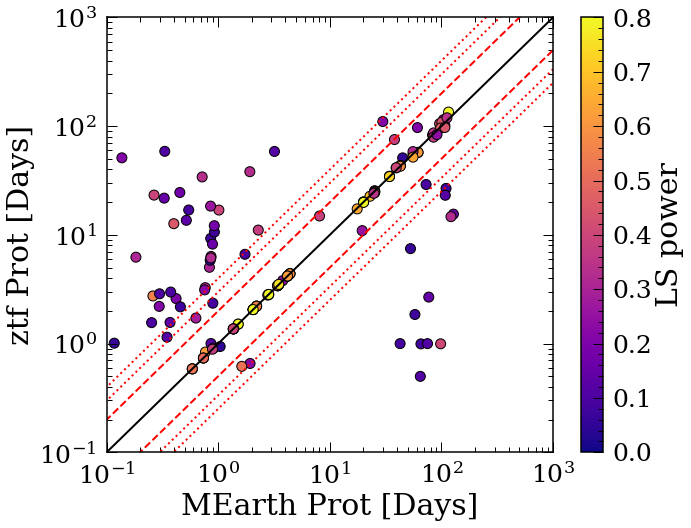

In [1016]:
import matplotlib.colors
def getcolor(vrange,cm=plt.cm.get_cmap('jet')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    return [cmap(norm(i)) for i in vrange]
colors = getcolor(np.array([1,2,3,4,5,6]),plt.cm.get_cmap('plasma'))

cmap = plt.cm.get_cmap('plasma')
plt.figure(figsize=(10,8))
prots_pag = df_cm.loc[df_cm['overall']==0]
plt.scatter(prots_pag['P'], prots_pag['bestprot'], c=prots_pag['maxpower1'], s=100, 
                edgecolor='k', cmap=cmap, vmin=0, vmax=0.8)

for i in range(1,6):
    prots_pag = df_cm.loc[df_cm['overall'+str(i)]==1]
    plt.scatter(prots_pag['P'], prots_pag['prot'+str(i)], 
                c=prots_pag['maxpower'+str(i)], s=100, 
                edgecolor='k', label='At least one season agrees', 
                cmap=cmap, vmin=0, vmax=0.8)
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,1000], [0,1000], 'k-')
plt.plot([0,3000], [0,6000], 'r--')
plt.plot([0,6000], [0,3000], 'r--')
plt.plot([0,9000], [0,3000], 'r:')
plt.plot([0,12000], [0,3000], 'r:')
plt.plot([0,3000],[0,9000], 'r:')
plt.plot([0,3000], [0,12000], 'r:')
plt.xlim([0.1,1000])
plt.ylim([0.1,1000])

cb = plt.colorbar()
cb.set_label('LS power')

In [1017]:
df_cm_2 = pd.merge(df_cm, eyecheck, left_on='2MASS', right_on='2MASS', how='left')

poss_numb = np.zeros(len(df_cm_2))
posses = df_cm_2['poss'].values
overallcheck = df_cm_2['overall'].values

for i in range(len(df_cm_2)):
    if overallcheck[i]==1:
        poss_numb[i] = 1
    elif posses[i]=='y':
        poss_numb[i] = 2
    elif posses[i]=='imp':
        poss_numb[i] = 3
    elif posses[i]=='ztf':
        poss_numb[i] = 4
    elif posses[i]=='?':
        poss_numb[i] = 5
    else:
        poss_numb[i] = 6
df_cm['poss_numb'] = poss_numb


df_cm['overall1'] = (abs(df_cm['prot1']-df_cm['P'])/df_cm['P'])<0.1
df_cm['overall2'] = ((abs(df_cm['prot2']-df_cm['P'])/df_cm['P'])<0.1)&(df_cm['overall1']!=1)
df_cm['overall3'] = ((abs(df_cm['prot3']-df_cm['P'])/df_cm['P'])<0.1)&(df_cm['overall1']!=1)&(df_cm['overall2']!=1)
df_cm['overall4'] = ((abs(df_cm['prot4']-df_cm['P'])/df_cm['P'])<0.1)&(df_cm['overall1']!=1)&(df_cm['overall2']!=1)&(df_cm['overall3']!=1)
df_cm['overall5'] = ((abs(df_cm['prot5']-df_cm['P'])/df_cm['P'])<0.1)&(df_cm['overall1']!=1)&(df_cm['overall2']!=1)&(df_cm['overall3']!=1)&(df_cm['overall4']!=1)

goodp = (abs(df_cm['prot1']-df_cm['P'])/df_cm['P'])<0.1
goodp = goodp|((abs(df_cm['prot2']-df_cm['P'])/df_cm['P'])<0.1)
goodp = goodp|((abs(df_cm['prot3']-df_cm['P'])/df_cm['P'])<0.1)
goodp = goodp|((abs(df_cm['prot4']-df_cm['P'])/df_cm['P'])<0.1)
goodp = goodp|((abs(df_cm['prot5']-df_cm['P'])/df_cm['P'])<0.1)
prots_raw['overall'] = goodp
print(sum(df_cm['overall1']),sum(df_cm['overall2']),sum(df_cm['overall3']),
      sum(df_cm['overall4']),sum(df_cm['overall5']))
print(sum(goodp), sum(goodp)/len(prots_raw))



22 9 2 4 1
38 0.3838383838383838


In [1018]:
df_cm = df_cm.reset_index(drop=True)
prot_ag = np.zeros(len(df_cm))
count = 0
for i in range(len(df_cm)):
    df_sing = df_cm.iloc[i]
    for j in range(1,6):
        if df_sing['overall'+str(j)]==1:
            prot_ag[i] = df_sing['prot'+str(j)]
            count = count+1
            break
        prot_ag[i] = df_sing['bestprot']
        
            
df_cm['prot_season'] = prot_ag


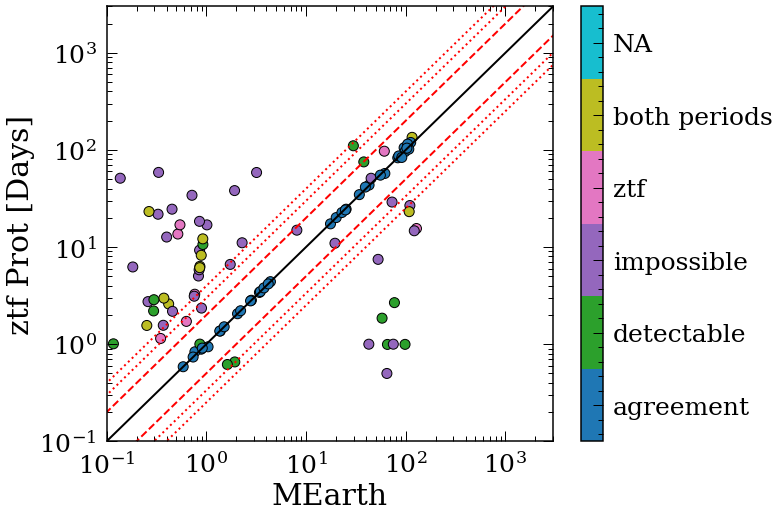

In [1019]:
plt.figure(figsize=(10,8))
plt.scatter(df_cm['P'], df_cm['prot_season'], c=df_cm['poss_numb'], s=100, 
            edgecolor='k', vmin=0.5, vmax=6.5, cmap=plt.cm.get_cmap('tab10',6))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,3000], [0,3000], 'k-')
plt.plot([0,3000], [0,6000], 'r--')
plt.plot([0,6000], [0,3000], 'r--')
plt.plot([0,9000], [0,3000], 'r:')
plt.plot([0,12000], [0,3000], 'r:')
plt.plot([0,3000],[0,9000], 'r:')
plt.plot([0,3000], [0,12000], 'r:')
plt.xlim([0.1,3000])
plt.ylim([0.1,3000])
cb = plt.colorbar(ticks=[1, 2, 3, 4, 5, 6])
cb.set_ticklabels(['agreement', 'detectable', 'impossible', 'ztf', 'both periods', 'NA'])




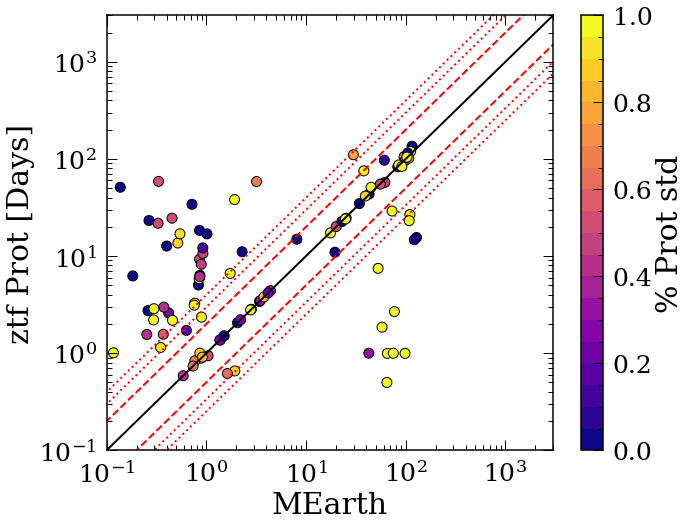

In [1023]:
plt.figure(figsize=(10,8))
plt.scatter(df_cm['P'], df_cm['prot_season'], c=df_cm['Prot_std'], s=100, 
            edgecolor='k', vmin=0, vmax=1, cmap=plt.cm.get_cmap('plasma',20))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,3000], [0,3000], 'k-')
plt.plot([0,3000], [0,6000], 'r--')
plt.plot([0,6000], [0,3000], 'r--')
plt.plot([0,9000], [0,3000], 'r:')
plt.plot([0,12000], [0,3000], 'r:')
plt.plot([0,3000],[0,9000], 'r:')
plt.plot([0,3000], [0,12000], 'r:')
plt.xlim([0.1,3000])
plt.ylim([0.1,3000])
cb = plt.colorbar()
cb.set_label('% Prot std')



7.57503590414002e-05


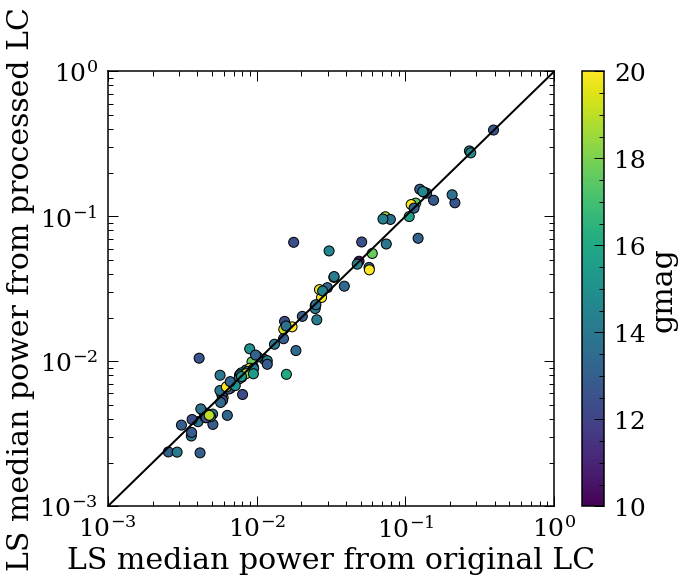

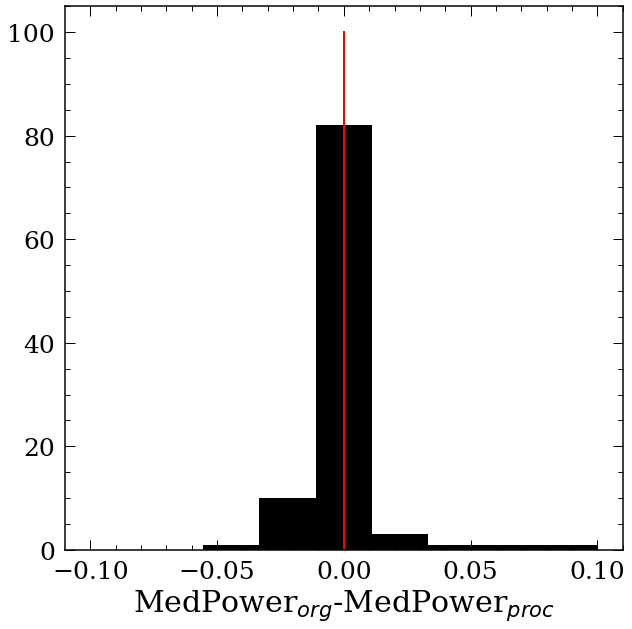

In [817]:
plt.figure(figsize=(10,8))
plt.scatter(df_cm['medpower_org'], df_cm['medpower1'],c=df_cm['gmag'], s=100, 
            edgecolor='k',vmin=10,vmax=20)
plt.plot([0,1], [0,1], 'k-')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-3,1])
plt.ylim([1e-3,1])
plt.xlabel('LS median power from original LC')
plt.ylabel('LS median power from processed LC')
cb = plt.colorbar()
cb.set_label('gmag')

plt.figure()
plt.hist(df_cm['medpower_org']-df_cm['medpower1'],bins=np.linspace(-0.1,0.1,10),
        color='k');
plt.plot([0,0],[0,100],'r-')
plt.xlabel('MedPower$_{org}$-MedPower$_{proc}$')

print(np.median(df_cm['medpower_org']-df_cm['medpower1']))

# Process for more stars

In [67]:
prots_raw = pd.read_table('ztfProts_split_newrun', delimiter=',')



In [75]:
pwd

'/data/users/llu'

In [68]:
for i in range(1,8):
    prots_raw['SN'+str(i)]=prots_raw['maxpower'+str(i)]/prots_raw['medpower'+str(i)]

    bestid = prots_raw['id'].values
bestprot = np.zeros(len(prots_raw))
bestsn = np.zeros(len(prots_raw))

for i in trange(len(bestid)):
    prots_sing = prots_raw.iloc[i]
    allsn = np.array([prots_sing['SN'+str(j)] for j in range(1,8)])
    #allsn = np.array([prots_sing['medpower'+str(j)] for j in range(1,8)])
    allsn = allsn[allsn==allsn]
    bestprot[i] = prots_sing['prot'+str(np.argmax(allsn)+1)]
    #bestprot[i] = prots_sing['prot'+str(np.argmin(allsn)+1)]
    bestsn[i] = min(allsn)
prots_raw['bestprot'] = bestprot
prots_raw['bestSN'] = bestsn

df_cm = pd.merge(radec[['2MASS','Prot','Gmag']], prots_raw, left_on='2MASS', right_on='id', how='inner')




100%|██████████| 336/336 [00:00<00:00, 7697.44it/s]


86 336 0.25595238095238093


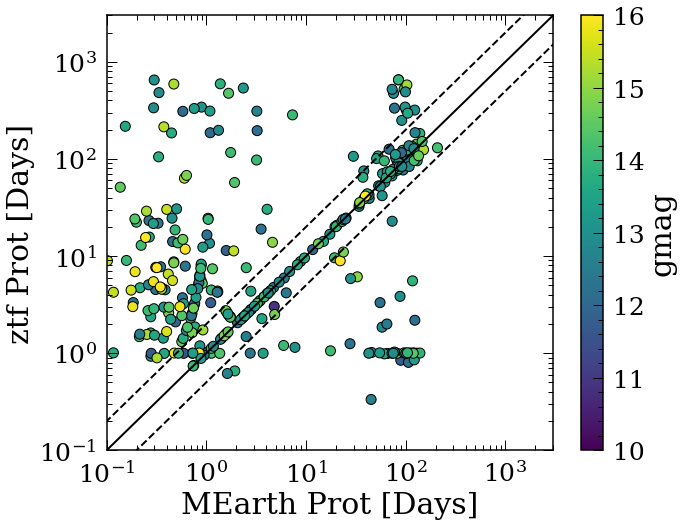

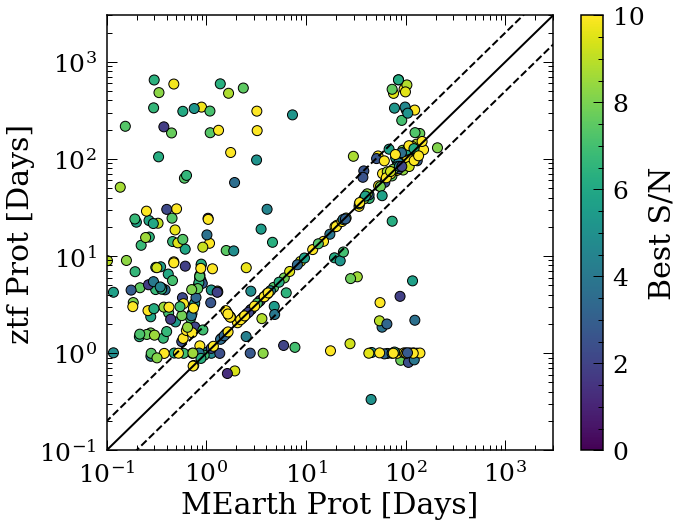

In [69]:
plt.figure(figsize=(10,8))
plt.scatter(df_cm['Prot'], df_cm['bestprot'], c=df_cm['Gmag'], s=100, 
            edgecolor='k', vmin=10, vmax=16)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,3000], [0,3000], 'k-')
plt.plot([0,3000], [0,6000], 'k--')
plt.plot([0,6000], [0,3000], 'k--')
plt.xlim([0.1,3000])
plt.ylim([0.1,3000])
cb = plt.colorbar()
cb.set_label('gmag')

plt.figure(figsize=(10,8))
plt.scatter(df_cm['Prot'], df_cm['bestprot'], c=df_cm['bestSN'], s=100, 
            edgecolor='k',vmin=0,vmax=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,3000], [0,3000], 'k-')
plt.plot([0,3000], [0,6000], 'k--')
plt.plot([0,6000], [0,3000], 'k--')
plt.xlim([0.1,3000])
plt.ylim([0.1,3000])
cb = plt.colorbar()
cb.set_label('Best S/N')

goodp = (abs(df_cm['bestprot']-df_cm['Prot'])/df_cm['Prot'])<0.1

print(sum(goodp), len(df_cm), sum(goodp)/len(df_cm))

In [70]:
goodids = df_cm[goodp]['2MASS'].values

In [71]:


goodp = (abs(df_cm['bestprot']-df_cm['Prot'])/df_cm['Prot'])<0.1

print('Best period:', sum(goodp), len(df_cm), sum(goodp)/len(df_cm))


df_cm['overall1'] = (abs(df_cm['prot1']-df_cm['Prot'])/df_cm['Prot'])<0.1
df_cm['overall2'] = (abs(df_cm['prot2']-df_cm['Prot'])/df_cm['Prot'])<0.1
df_cm['overall3'] = (abs(df_cm['prot3']-df_cm['Prot'])/df_cm['Prot'])<0.1
df_cm['overall4'] = (abs(df_cm['prot4']-df_cm['Prot'])/df_cm['Prot'])<0.1
df_cm['overall5'] = (abs(df_cm['prot5']-df_cm['Prot'])/df_cm['Prot'])<0.1
df_cm['overall6'] = (abs(df_cm['prot6']-df_cm['Prot'])/df_cm['Prot'])<0.1
df_cm['overall7'] = (abs(df_cm['prot7']-df_cm['Prot'])/df_cm['Prot'])<0.1
goodp = (abs(df_cm['prot1']-df_cm['Prot'])/df_cm['Prot'])<0.1
goodp = goodp|((abs(df_cm['prot2']-df_cm['Prot'])/df_cm['Prot'])<0.1)
goodp = goodp|((abs(df_cm['prot3']-df_cm['Prot'])/df_cm['Prot'])<0.1)
goodp = goodp|((abs(df_cm['prot4']-df_cm['Prot'])/df_cm['Prot'])<0.1)
goodp = goodp|((abs(df_cm['prot5']-df_cm['Prot'])/df_cm['Prot'])<0.1)
goodp = goodp|((abs(df_cm['prot6']-df_cm['Prot'])/df_cm['Prot'])<0.1)
goodp = goodp|((abs(df_cm['prot7']-df_cm['Prot'])/df_cm['Prot'])<0.1)
df_cm['overall'] = goodp
print(sum(df_cm['overall1']),sum(df_cm['overall2']),sum(df_cm['overall3']),
      sum(df_cm['overall4']),sum(df_cm['overall5']),sum(df_cm['overall6']),
     sum(df_cm['overall7']))
print(sum(goodp), sum(goodp)/len(df_cm))



bestid = df_cm['2MASS'].values
bestprot = np.zeros(len(df_cm))
maxprot = np.zeros(len(df_cm))
same2 = np.zeros(len(df_cm))
pstd = np.zeros(len(df_cm))

for i in trange(len(bestid)):
    prots_sing = df_cm.loc[df_cm['2MASS']==bestid[i]]
    oneprot = prots_sing[['prot1','prot2','prot3','prot4','prot5']].dropna(axis=1).values[0]
    maxpowers = prots_sing[['maxpower1','maxpower2','maxpower3','maxpower4','maxpower5']].dropna(axis=1).values[0]
    pstd[i] = np.std(oneprot)/np.mean(oneprot)
    if len(oneprot)<3:
        bestprot[i] = oneprot[maxpowers==max(maxpowers)]
        maxprot[i] = oneprot[maxpowers==max(maxpowers)]
        same2[i]=0
        continue
    oneprot_test = np.append(oneprot, [oneprot[0]])
    smalldiff = min(abs(np.diff(oneprot_test)))
    m2 = (abs(np.diff(oneprot_test))==min(abs(np.diff(oneprot_test))))
    m2 = np.append(m2,[False])
    if smalldiff/oneprot_test[m2]<0.05:
        bestprot[i]=oneprot_test[m2]
        same2[i]=1
    else:
        bestprot[i] = oneprot[maxpowers==max(maxpowers)]
        same2[i]=0
    maxprot[i] = oneprot[maxpowers==max(maxpowers)]
    
    
df_cm['bestprot'] = bestprot
df_cm['bestSN'] = bestsn    
df_cm['Prot_std'] = pstd


agreem = abs(df_cm['bestprot']-df_cm['Prot'])/df_cm['Prot']<0.1
multiseason = same2==1
agreem_2 = abs(df_cm['bestprot'][multiseason]-df_cm['Prot'][multiseason])/df_cm['Prot'][multiseason]<0.1
agreem_3 = abs(df_cm['bestprot'][~multiseason]-df_cm['Prot'][~multiseason])/df_cm['Prot'][~multiseason]<0.1


print('best agreeing:', sum(agreem))
print('at least 2 agreeing:', sum(agreem_2), sum(multiseason))
print('best agreeing:', sum(agreem_3), len(multiseason)-sum(multiseason))


Best period: 86 336 0.25595238095238093
78 54 65 63 25 0 0
130 0.3869047619047619


100%|██████████| 336/336 [00:00<00:00, 349.50it/s]

best agreeing: 91
at least 2 agreeing: 58 149
best agreeing: 33 187


In [72]:
58/147

0.3945578231292517

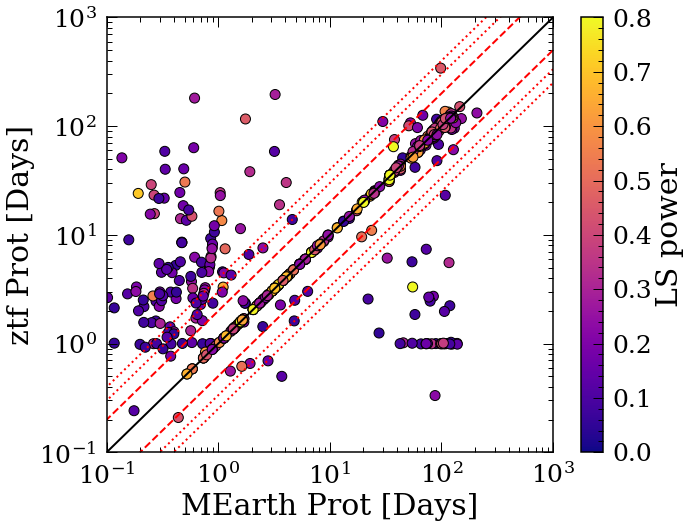

In [73]:
import matplotlib.colors
def getcolor(vrange,cm=plt.cm.get_cmap('jet')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    return [cmap(norm(i)) for i in vrange]
colors = getcolor(np.array([1,2,3,4,5,6]),plt.cm.get_cmap('plasma'))

cmap = plt.cm.get_cmap('plasma')
plt.figure(figsize=(10,8))
prots_pag = df_cm.loc[df_cm['overall']==0]
plt.scatter(prots_pag['Prot'], prots_pag['bestprot'], c=prots_pag['maxpower1'], s=100, 
                edgecolor='k', cmap=cmap, vmin=0, vmax=0.8)

for i in range(1,6):
    prots_pag = df_cm.loc[df_cm['overall'+str(i)]==1]
    plt.scatter(prots_pag['Prot'], prots_pag['prot'+str(i)], 
                c=prots_pag['maxpower'+str(i)], s=100, 
                edgecolor='k', label='At least one season agrees', 
                cmap=cmap, vmin=0, vmax=0.8)
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MEarth Prot [Days]')
plt.ylabel('ztf Prot [Days]')
plt.plot([0,1000], [0,1000], 'k-')
plt.plot([0,3000], [0,6000], 'r--')
plt.plot([0,6000], [0,3000], 'r--')
plt.plot([0,9000], [0,3000], 'r:')
plt.plot([0,12000], [0,3000], 'r:')
plt.plot([0,3000],[0,9000], 'r:')
plt.plot([0,3000], [0,12000], 'r:')
plt.xlim([0.1,1000])
plt.ylim([0.1,1000])

cb = plt.colorbar()
cb.set_label('LS power')

5.8533161211700175e-05


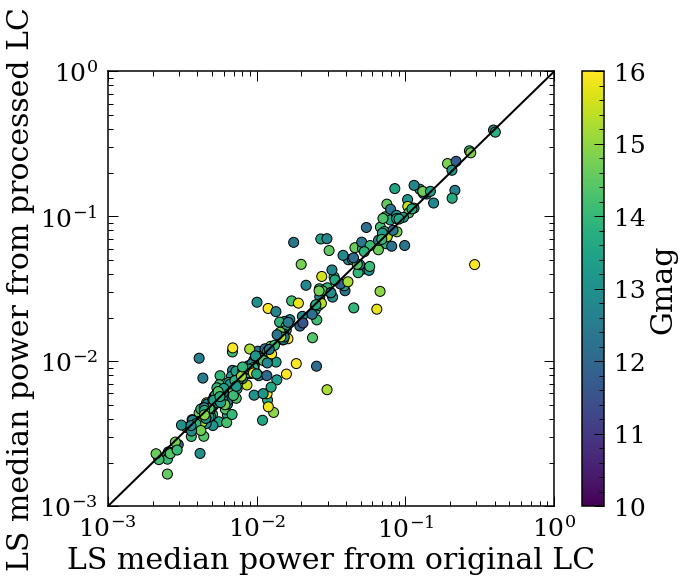

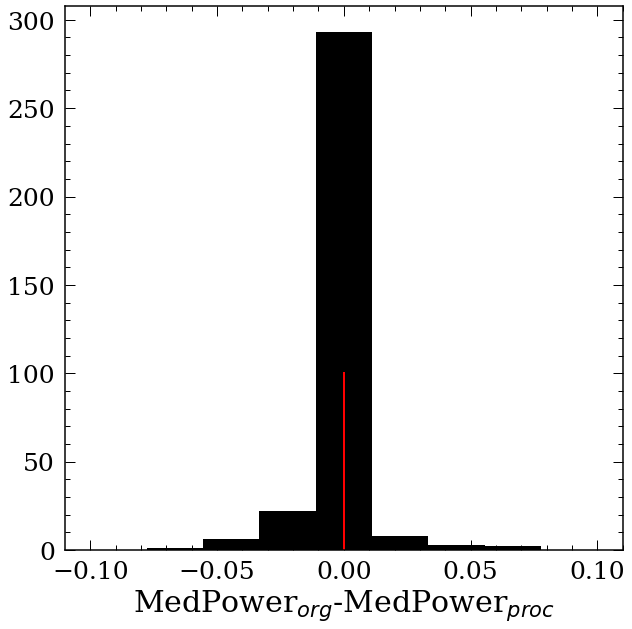

In [74]:
plt.figure(figsize=(10,8))
plt.scatter(df_cm['medpower_org'], df_cm['medpower1'],c=df_cm['Gmag'], s=100, 
            edgecolor='k',vmin=10,vmax=16)
plt.plot([0,1], [0,1], 'k-')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-3,1])
plt.ylim([1e-3,1])
plt.xlabel('LS median power from original LC')
plt.ylabel('LS median power from processed LC')
cb = plt.colorbar()
cb.set_label('Gmag')

plt.figure()
plt.hist(df_cm['medpower_org']-df_cm['medpower1'],bins=np.linspace(-0.1,0.1,10),
        color='k');
plt.plot([0,0],[0,100],'r-')
plt.xlabel('MedPower$_{org}$-MedPower$_{proc}$')

print(np.median(df_cm['medpower_org']-df_cm['medpower1']))